AI Reconstruction of population-scale structured networks from social surveys

In [ ]:
import nd_python as nd_p
import numpy as np
import pandas as pd
import json

n, iters = 100_000, 30
df = pd.read_csv('input_data/comix3.csv', sep=',')
egos, contact_matrix, params = nd_p.fit_to_data(df=df, dist_type='dpln')

np.savetxt('input_data/parameters/params_comix3_dpln.csv',params,delimiter=',')
np.savetxt('input_data/contact_matrices/contact_matrix_comix3_dpln.csv',contact_matrix,delimiter=',')
with open('input_data/egos/comix3.json', 'w') as f:
    json.dump([{'age': a['age'], 'contacts': list(a['contacts']), 'degree': a['degree']} for a in egos], f)

_, _, params = nd_p.fit_to_data(df=df, dist_type='nbinom')
np.savetxt('input_data/parameters/params_comix3_nbinom.csv',params,delimiter=',')

# Figs for Paper

## Contact Matrices

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np
plt.rcParams.update({'font.size': 24}) 








New Dataset 










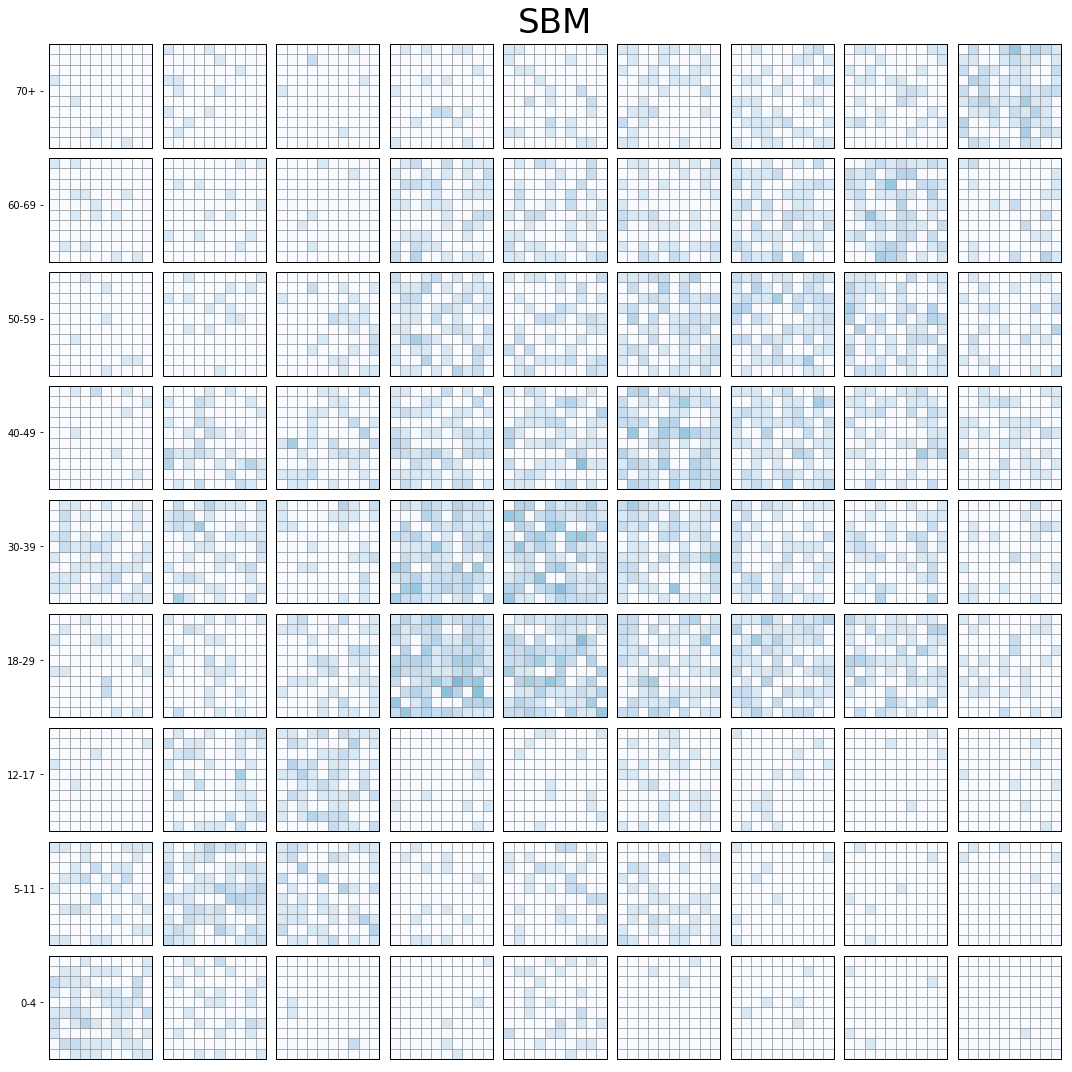

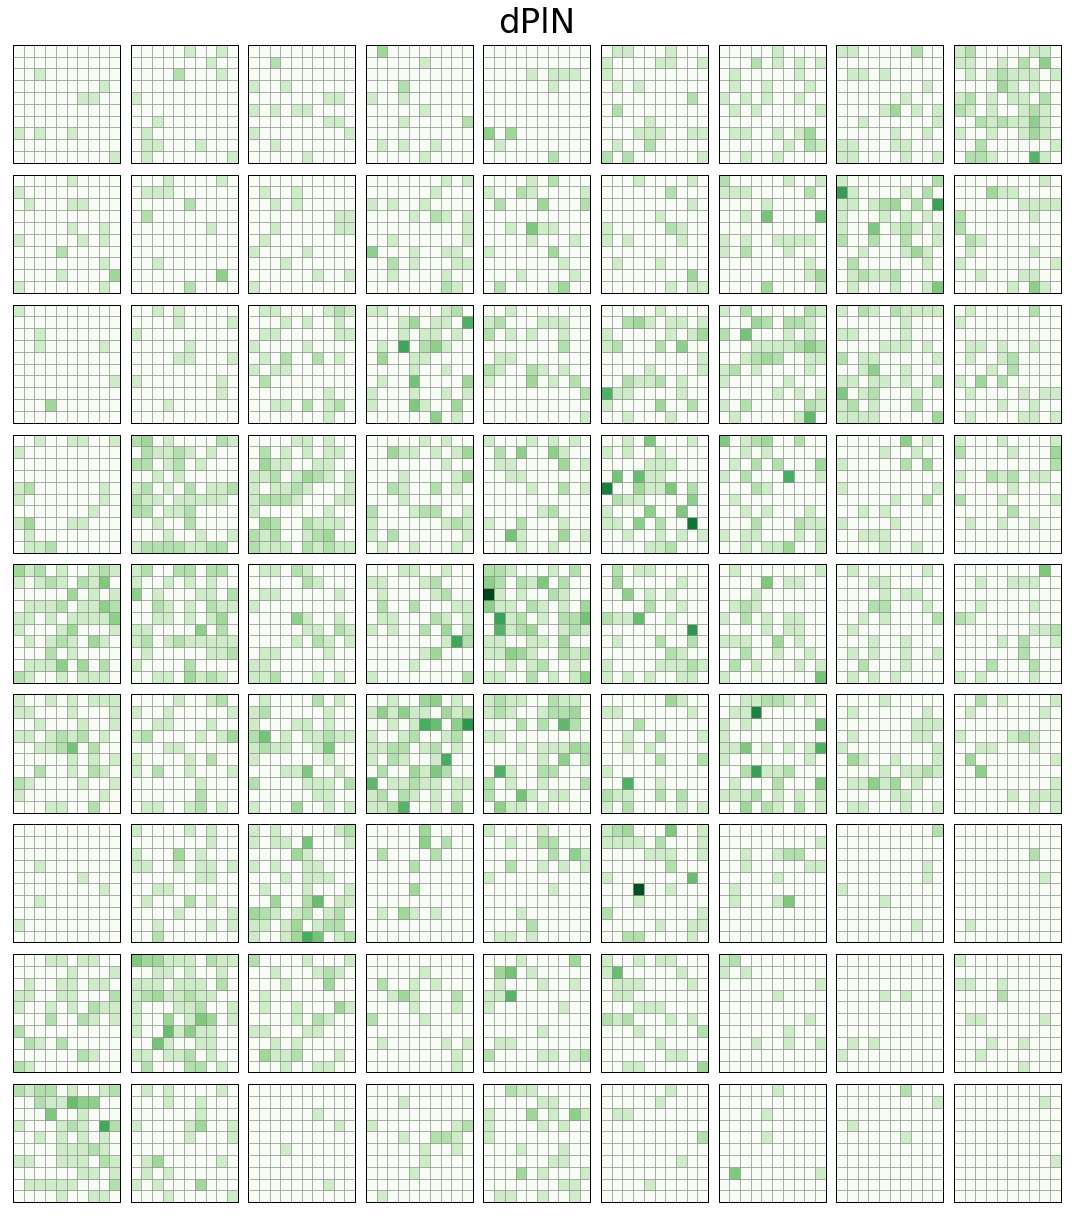

FileNotFoundError: [Errno 2] No such file or directory: 'output_data/egos/comix1_gmm.json'

In [4]:
# datas = ['CoMix_p1', 'CoMix_p2', 'polymod_df']
data_titles = ['CoMix 1', 'CoMix 2', 'Comix3', 'POLYMOD']
egos = ['comix1', 'comix2', 'comix3' 'poly']
models = ['sbm','dpln', 'gmm', 'data']
model_names = ['SBM', 'dPlN', 'GMM', 'Data']

num_rows, epsilon = 9, 1e-1
width = 1/(num_rows+epsilon*num_rows)
num_small = 10
max_degree = 100
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
num_samples = num_small**2
cmap_grey = plt.get_cmap('Greys')
inside_g, outside_g = 0.1,0.5

for data_idx, data in enumerate(egos):
    print(f'\n\n\n\n\n\n\nNew Dataset \n\n\n\n\n\n\n\n')
    for model_idx, model in enumerate(models): 
        
        if model =='data':
            with open(f'output_data/egos/egos_{egos[data_idx]}.json') as f:
                ego_networks = json.load(f)
            print(f'{data} {model}: {np.mean([a["degree"] for a in ego_networks])}')
            ## count the partitions of data set
            data_partitions = np.zeros(len(partitions))
            for ego in ego_networks:
                data_partitions[ego['age']] += 1
            # make cumulative
            data_partitions = np.cumsum(data_partitions)
            # randomly sample in partitions
            samples = np.zeros((len(partitions), len(partitions), num_samples))
            for i, top in enumerate(data_partitions):
                for j, _ in enumerate(data_partitions):
                    if i == 0:    
                        indices = np.random.randint(0, top, size=num_samples)
                    else:
                        indices = np.random.randint(data_partitions[i-1], top, size=num_samples)
                    for k, idx in enumerate(indices):
                        # print(f'shape: {np.shape(samples)} \ni: {i}\nj: {j}\nk: {k}\n idx: {idx}\nlen(egos): {len(ego_networks)}\n {len(ego_networks[idx]["contacts"])}')
                        samples[i,j,k] = ego_networks[idx]['contacts'][j]
                        
        else:  
            # read in the example network
            with open(f'output_data/egos/{data}_{model}.json') as f:
                network = json.load(f)

            #preprocessing
            # randomly sample in partitions
            samples = np.zeros((len(partitions), len(partitions), num_samples))
            for i, top in enumerate(partitions):
                for j, _ in enumerate(partitions):
                    if i == 0:    
                        indices = np.random.randint(0, top, size=num_samples)
                    else:
                        indices = np.random.randint(partitions[i-1], top, size=num_samples)
                    for k, idx in enumerate(indices):
                        samples[i, j, k] = network['frequency_distribution'][idx][j]

        if data != egos[0] and model != models[0]:
            fig, ax = plt.subplots(figsize=(17,17))
        elif data != egos[0]:
            fig, ax = plt.subplots(figsize=(17,15)) 
        elif model != models[0]:
            fig, ax = plt.subplots(figsize=(15,17))           
        else:
            fig, ax = plt.subplots(figsize=(15,15))
        # cmap = plt.get_cmap('viridis')
        if model == models[0]:
            cmap = plt.get_cmap('Blues')
        elif model == models[1]:
            cmap = plt.get_cmap('Greens')
        else:
            # cmap =plt.get_cmap('OrRd')
            cmap=plt.get_cmap('binary')
        
        max_val_test = 0
        for i in range(num_rows):
            for j in range(num_rows):
                # shuffle to make it prettier
                box_samples = samples[i,j,:]
                np.random.shuffle(box_samples)
                for k in range(num_small):
                    for l in range(num_small):
                        # small squares
                        if box_samples[k*num_small + l] >= max_val_test:
                            max_val_test = box_samples[k*num_small + l]
                            # print(max_val_test)
                        # linear (pretty bad)
                        # norm_degree = box_samples[k*num_small + l] / max_degree if box_samples[k*num_small + l] < max_degree else (max_degree-1)/max_degree
                        # square root (pretty good)
                        # norm_degree = np.sqrt(box_samples[k*num_small + l] / max_degree) if box_samples[k*num_small + l] < max_degree else np.sqrt((max_degree-1)/max_degree)
                        # log scale
                        norm_degree = (np.log(box_samples[k*num_small + l]+1) - np.log(1)) / (np.log(max_degree+1) - np.log(1)) if box_samples[k*num_small + l] < max_degree else (max_degree-1)/max_degree
                        #green colorbar too light. change in colorbar too
                        if model == models[1]:
                            if norm_degree != 0:
                                norm_degree = norm_degree**0.8
                        # norm_degree = norm_degree**0.9
                        
                        colour = cmap(norm_degree)
                        rect = patches.Rectangle(((i+epsilon/2)/num_rows + k*width/num_small, (j+epsilon/2)/num_rows + l*width/num_small), width/num_small, width/num_small, linewidth=0.5, edgecolor='grey', facecolor=colour)
                        grey = cmap_grey(inside_g)
                        # rect = patches.Rectangle(((i+epsilon/2)/num_rows + k*width/num_small, (j+epsilon/2)/num_rows + l*width/num_small), width/num_small, width/num_small, linewidth=0.5, edgecolor=grey, facecolor=colour)
                        
                        ax.add_patch(rect)
                # big squares
                grey = cmap_grey(outside_g)
                # rect = patches.Rectangle(((i+epsilon/2)/num_rows, (j+epsilon/2)/num_rows), width, width, linewidth=1, edgecolor=grey, facecolor='none')
                rect = patches.Rectangle(((i+epsilon/2)/num_rows, (j+epsilon/2)/num_rows), width, width, linewidth=1, edgecolor='k', facecolor='none')
                ax.add_patch(rect)
                
        buckets = ['0-4', '5-11', '12-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70+']
        plt.xticks(rotation=60)
        ax.set_xticks([(i + (1 + epsilon)/2)/num_rows for i in range(num_rows)], buckets)
        ax.set_yticks([(i + (1 + epsilon)/2)/num_rows for i in range(num_rows)], buckets)
        # ax.tick_params(color='white')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if data == egos[0]:
            plt.title(f'{model_names[model_idx]}', fontsize=34)
        #     for index in range(len(model_names)):
        #         if model == models[-1]:
        #             plt.title(f'{data_titles[data_idx]}: {model_names[index]}', fontsize=40)
        #         if models[index] == model:
        #             plt.title(f'{model_names[index]}', fontsize=40) 
        # plt.title(f'{data_titles[data_idx]}')
        # plt.title(f'{model_names[model_idx]}')
        
        if data != egos[2]:
            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if model != models[0]:
            plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelleft=False)
        
            
        # plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'output_data/figs/cm_{data}_{model}.pdf', format='pdf')
        plt.show()

## Errors

In [5]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns



oops no output_data/errors/comix3_sbm.csv

oops no output_data/errors/comix3_nbinom.csv

oops no output_data/errors/comix3_dpln.csv

oops no output_data/errors/comix3_gmm.csv

oops no output_data/errors/poly_sbm.csv

oops no output_data/errors/poly_nbinom.csv

oops no output_data/errors/poly_dpln.csv

oops no output_data/errors/poly_gmm.csv

n-Binomial: 1.6652313822287896
SBM: 2.9897854316055543
GMM: 0.8426425921263191
dPlN: 0.9833568232804438
n-Binomial: 1.6652313822287896
SBM: 2.9897854316055543
GMM: 0.8426425921263191
dPlN: 0.9833568232804438
n-Binomial: 1.6652313822287896
SBM: 2.9897854316055543
GMM: 0.8426425921263191
dPlN: 0.9833568232804438


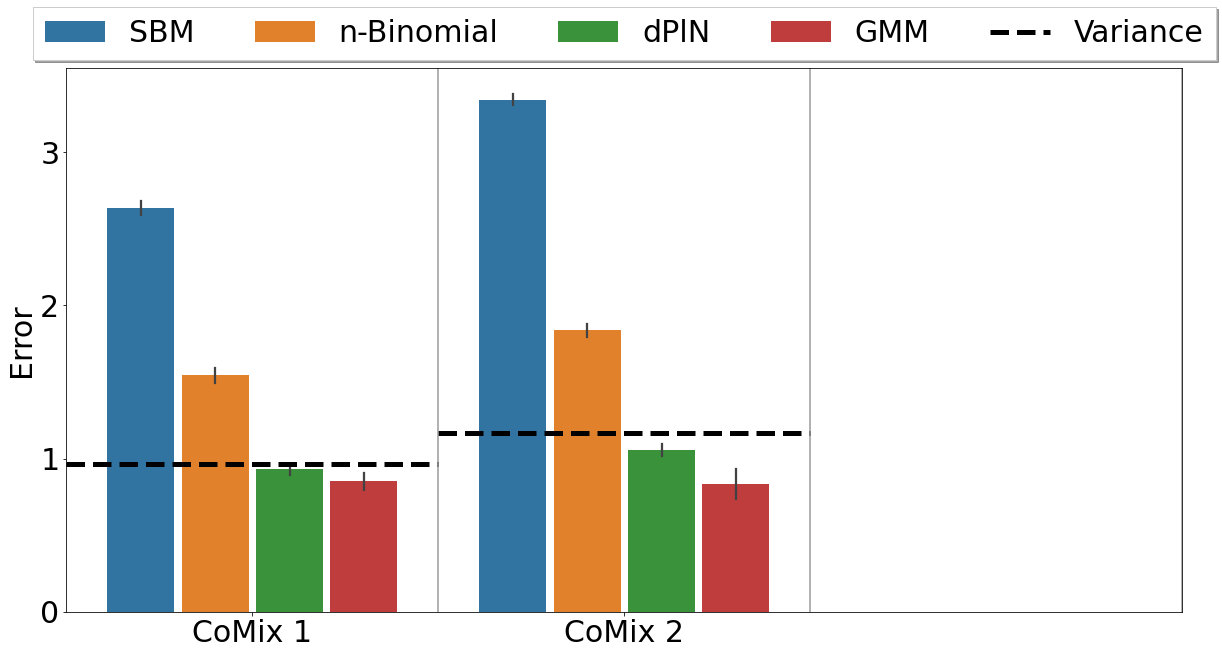

In [6]:
datas = ['comix1', 'comix2', 'comix3', 'poly']
models = ['sbm', 'nbinom', 'dpln','gmm']
data_names = ['CoMix 1', 'CoMix 2', 'CoMix 3' 'POLYMOD']
model_names = ['SBM', 'n-Binomial', 'dPlN','GMM']

df, var = pd.DataFrame({}), pd.DataFrame({})
for i, data in enumerate(datas):
    for j, model in enumerate(models):
        try:
            tmp = np.loadtxt(f'output_data/errors/{data}_{model}.csv', delimiter=',')
            df = pd.concat([df, pd.DataFrame({'Error': tmp, 'Model': [f'{model_names[j]}' for _ in range(len(tmp))], 'Data': [f'{data_names[i]}' for _ in range(len(tmp))]})])
        except:
            print(f'oops no output_data/errors/{data}_{model}.csv')
        try: 
            tmp_var = np.loadtxt(f'output_data/errors/itself_{data}_{model}.csv', delimiter=',')
            var = pd.concat([var, pd.DataFrame({'Error': tmp_var, 'Model': [f'{model_names[j]}' for _ in range(len(tmp_var))], 'Data': [f'{data_names[i]}' for _ in range(len(tmp_var))]})])
        except:
            print(f'')

plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
df_reduced = df[df['Model'] != 'Reconstruction']

sns.barplot(data=df_reduced, x='Data', y='Error', hue='Model',errorbar=('sd',3), gap=0.1)

for data in data_names:
    df_less = df_reduced[df_reduced['Data'] == data]
    for key in set(df_reduced['Model']):
        print(f"{key}: {np.mean(df_reduced[df_reduced['Model'] == key]['Error'])}")
        
## variance line
for i, data in enumerate(data_names):
    var_less = var[var['Data'] == data]
    mean = np.mean(var_less['Error'])
    plt.plot([-1/2+i,1/2+i],[mean, mean], '--k', linewidth = 5, label='Variance' if i==0 else '') 

# sns.violinplot(data=df_reduced, x='Data', y='Error', hue='Model')
# sns.boxplot(data=df, x='Data', y='Error', hue='Model')
# plt.yscale('log')

for pos in range(3):  # Skip the last position
    plt.axvline(x=pos+1/2, color='gray', alpha=0.6, linewidth=2)
    # print(pos, np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error']))
    # plt.plot([pos-1/2+2e-3, pos+1/2-5e-3], [np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error']), np.mean(df[(df['Model'] == 'Reconstruction') & (df['Data'] == datas[pos])]['Error'])], 'k--', label='Model Variance' if pos==0 else '', linewidth=5)
plt.xlim([-1/2, 5/2])
plt.xlabel('')

plt.yticks([0,1,2,3])
# plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=5, fancybox=False, shadow=True)
plt.savefig('error_plots.png', bbox_inches='tight')

plt.show()

## Duration Scaling

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

df_c1 = pd.read_csv('input_data/comix1.csv', delimiter=',')
df_c2 = pd.read_csv('input_data/comix2.csv', delimiter=',')

############################################### CoMix 1 ########################################################'
bin_centers, bin_tops = [], [1,5,15,60,60*4,60*24]
for i, top in enumerate(bin_tops[1:]):
    gmean = sc.stats.mstats.gmean(list(range(bin_tops[i], top)))
    bin_centers.append(gmean)
    #try lower bounds
    # bin_centers.append(bin_tops[i])

bin_centers.append(bin_centers[0])
 

dur_counts_c1, freq_counts_c1 = np.zeros((len(set(df_c1['part_id'])), 6)), np.zeros((len(set(df_c1['part_id'])), 6)) 
for part_index, part_id in enumerate(set(df_c1['part_id'])):
    df_tmp = df_c1[df_c1['part_id'] == part_id]
    for _, row in df_tmp.iterrows():
        if np.isnan(row['duration_multi']):
            dur_counts_c1[part_index, -1] += 1
        else:
            dur_counts_c1[part_index, int(row['duration_multi'])-1] += 1
        
        if np.isnan(row['frequency_multi']):
            freq_counts_c1[part_index, -1] += 1
        else:
            freq_counts_c1[part_index, int(row['frequency_multi'])-1] += 1
            

xs, ys = [], []
for person in dur_counts_c1:
    if sum(person[:-1]) >0:
        xs.append(sum(person))
        ys.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
    
# sort lists 
# Pair each element with its original index using enumerate
indexed_list = list(enumerate(xs)) 

# Sort the list by the elements while keeping the original indices
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])

# Extract the sorted elements and their original indices
sorted_xs = np.array([element for _, element in sorted_indexed_list])
original_indices = [index for index, _ in sorted_indexed_list]

sorted_ys = np.array([ys[original_indices[i]]/(60) for i, x in enumerate(xs)])
xs = list(range(1, int(max(sorted_xs))+1))
x_counts, ys = np.zeros(int(max(sorted_xs))), np.zeros(int(max(sorted_xs))) 

for i, y in enumerate(sorted_ys):
    x_counts[int(sorted_xs[i])-1] += 1
    ys[int(sorted_xs[i])-1] += y
    
############# try binning data ############

tmp, first, x_bins, x_tops = 0, 1, [], []
for i,x in enumerate(x_counts):
    tmp += x
    if tmp > 5:
        x_tops.append(i+1)    
        x_bins.append(sc.stats.mstats.gmean(list(range(first,i+2))))
        first = i+2
        tmp = 0

y_bins = np.zeros(len(x_tops)) 
for i, x_top in enumerate(x_tops):
    tmp_num, tmp_sum = 0, 0 
    for idx in range(0 if i==0 else x_tops[i-1], x_top):
        tmp_num += x_counts[idx]
        tmp_sum += ys[idx]
    y_bins[i] = tmp_sum/tmp_num

x_c1,y_c1,x_c1_counts = xs, ys/x_counts, x_counts

## binned
x_c1_bins, y_c1_bins = x_bins, y_bins

############################################## CoMix 2 ######################################################

dur_counts_c2, freq_counts_c2 = np.zeros((len(set(df_c2['part_id'])), 6)), np.zeros((len(set(df_c2['part_id'])), 6)) 
for part_index, part_id in enumerate(set(df_c2['part_id'])):
    df_tmp = df_c2[df_c2['part_id'] == part_id]
    for _, row in df_tmp.iterrows():
        if np.isnan(row['duration_multi']):
            dur_counts_c2[part_index, -1] += 1
        else:
            dur_counts_c2[part_index, int(row['duration_multi'])-1] += 1
        
        if np.isnan(row['frequency_multi']):
            freq_counts_c2[part_index, -1] += 1
        else:
            freq_counts_c2[part_index, int(row['frequency_multi'])-1] += 1
            

xs, ys = [], []
for person in dur_counts_c2:
    if sum(person[:-1]) >0:
        xs.append(sum(person))
        ys.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
    
# sort lists 
# Pair each element with its original index using enumerate
indexed_list = list(enumerate(xs)) 

# Sort the list by the elements while keeping the original indices
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])

# Extract the sorted elements and their original indices
sorted_xs = np.array([element for _, element in sorted_indexed_list])
original_indices = [index for index, _ in sorted_indexed_list]

sorted_ys = np.array([ys[original_indices[i]]/(60) for i, x in enumerate(xs)])
xs = list(range(1, int(max(sorted_xs))+1))
x_counts, ys = np.zeros(int(max(sorted_xs))), np.zeros(int(max(sorted_xs))) 

for i, y in enumerate(sorted_ys):
    x_counts[int(sorted_xs[i])-1] += 1
    ys[int(sorted_xs[i])-1] += y
    
    
############# try binning data ############

tmp, first, x_bins, x_tops = 0, 1, [], []
for i,x in enumerate(x_counts):
    tmp += x
    if tmp > 5:
        x_tops.append(i+1)    
        x_bins.append(sc.stats.mstats.gmean(list(range(first,i+2))))
        first = i+2
        tmp = 0

y_bins = np.zeros(len(x_tops)) 
for i, x_top in enumerate(x_tops):
    tmp_num, tmp_sum = 0, 0 
    for idx in range(0 if i==0 else x_tops[i-1], x_top):
        tmp_num += x_counts[idx]
        tmp_sum += ys[idx]
    y_bins[i] = tmp_sum/tmp_num
    
x_c2,y_c2, x_c2_counts = xs, ys/x_counts, x_counts

## binned
x_c2_bins, y_c2_bins = x_bins, y_bins

/tmp/ipykernel_20884/2406342283.py:79: RuntimeWarning: invalid value encountered in divide
  x_c1,y_c1,x_c1_counts = xs, ys/x_counts, x_counts
/tmp/ipykernel_20884/2406342283.py:146: RuntimeWarning: invalid value encountered in divide
  x_c2,y_c2, x_c2_counts = xs, ys/x_counts, x_counts


0.0 0.0006850398760138171
[ 1.92956894e-01  2.59704669e-01  3.80034378e+04  9.99807691e-01
 -3.79945575e+04]
[ 5.93873598e-02  1.81042228e-01  1.06873503e+05  9.99929091e-01
 -1.06864101e+05]


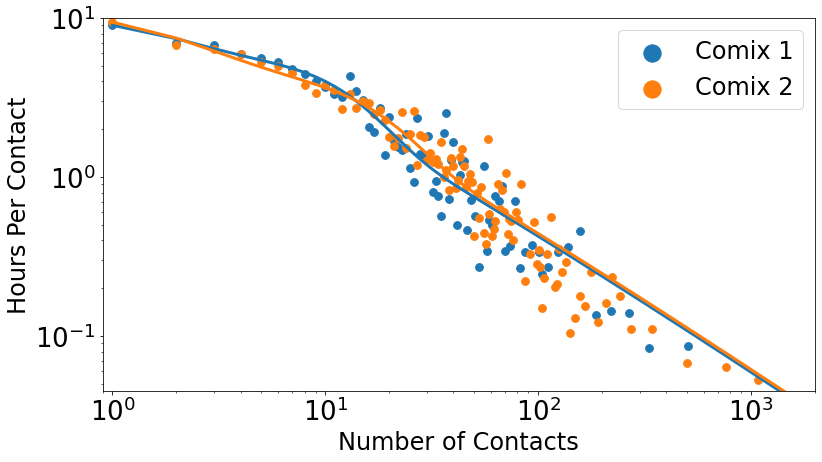

In [18]:
plt.rcParams.update({'font.size': 26})

def curve3(x, A, B, C, D, E):
    x = np.array(x)
    return A*np.exp(-B*x)*np.power(x,2) + C/np.power(x,D) + E/x 


x = list(range(1,max(x_c2)))
data, durations = [], []
for person in dur_counts_c1:
    if sum(person[:-1]) >0:
        data.append(sum(person))
        durations.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])
for person in dur_counts_c2:
    if sum(person[:-1]) >0:
        data.append(sum(person))
        durations.append(sum([a*bin_centers[i] for i,a in enumerate(person)]) / xs[-1])


## Remove Nans from data
x_c1 = [i for i, x in zip(x_c1 , y_c1) if not np.isnan(x)]
y_c1 = [a for a in y_c1 if not np.isnan(a)]

x_c2 = [i for i, x in zip(x_c2 , y_c2) if not np.isnan(x)]
y_c2 = [a for a in y_c2 if not np.isnan(a)]

plt.figure(figsize=(12, 7))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Hours Per Contact', fontsize=24)
plt.xlabel('Number of Contacts', fontsize=24)
## fit plots
# plt.scatter(x_c1 , np.array(y_c1), label='Comix 1')
# plt.scatter(x_c2, np.array(y_c2), label='Comix 2')
plt.scatter(x_c1_bins , np.array(y_c1_bins), s=60)
plt.scatter(x_c2_bins, np.array(y_c2_bins), s=60)
plt.scatter([-1],[-1], color = 'tab:blue', label='Comix 1', s=300)
plt.scatter([-1],[-1], color ='tab:orange', label='Comix 2', s=300)

####################################### fitting curve 3 #############################################
# # y = A*(x^2)*exp(-Bx) + C/(x^D) + E/x
print(min(np.log(data)), min(durations))
# p_opt1, _ = sc.optimize.curve_fit(curve1, data, durations, bounds=([0, -np.inf, 0],[np.inf, np.inf, 1]))
p_opt1, _ = sc.optimize.curve_fit(curve3, x_c1 , y_c1, bounds=([0, 0, 0, 0, -np.inf],[np.inf, np.inf, np.inf, 1, np.inf]))
print(p_opt1)
plt.plot(x, curve3(x,p_opt1[0], p_opt1[1], p_opt1[2], p_opt1[3], p_opt1[4]), linewidth=3)

p_opt2, _ = sc.optimize.curve_fit(curve3, x_c2, y_c2, bounds=([0, 0, 0, 0, -np.inf],[np.inf, np.inf, np.inf, 1, np.inf]))
print(p_opt2)
plt.plot(x, curve3(x,p_opt2[0], p_opt2[1], p_opt2[2], p_opt2[3], p_opt2[4]), linewidth=3)


# x2,y2 = xs, ys/x_counts
plt.xlim([9/10,2e3])
plt.ylim([4.5e-2,10])
plt.legend(prop={'size':24})
plt.tight_layout()
# plt.savefig('output/comix_dur_with_fits.pdf')
plt.show()


## Final Size and Peak Height

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import json

comix1 sbm 0
comix1 sbm 34
comix1 dpln 0
comix1 dpln 1
comix1 dpln 2
comix1 dpln 3
comix1 dpln 4
comix1 dpln 34
comix2 sbm 0
comix2 sbm 1
comix2 sbm 34
comix2 dpln 0
comix2 dpln 1
comix2 dpln 2
comix2 dpln 3
comix2 dpln 4
comix2 dpln 34
poly sbm 14
poly sbm 15
poly sbm 34
poly dpln 0
poly dpln 1
poly dpln 2
poly dpln 3
poly dpln 4
poly dpln 11
poly dpln 12
poly dpln 13
poly dpln 14
poly dpln 15
poly dpln 34
poly dpln 35


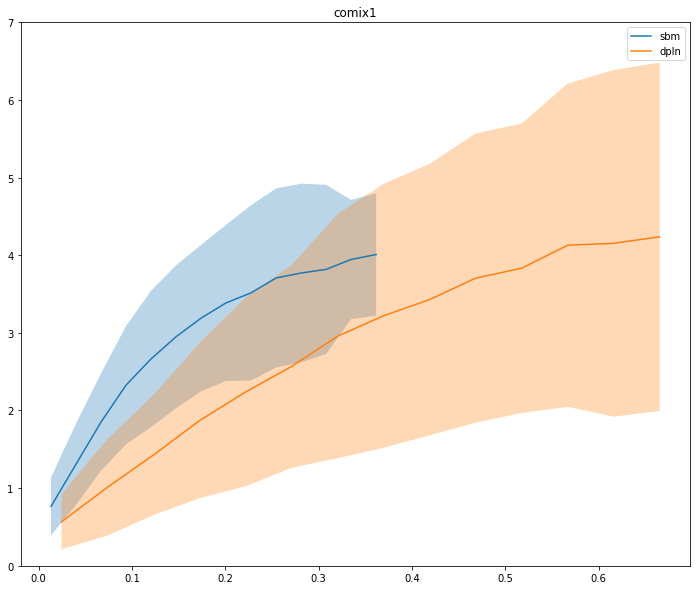

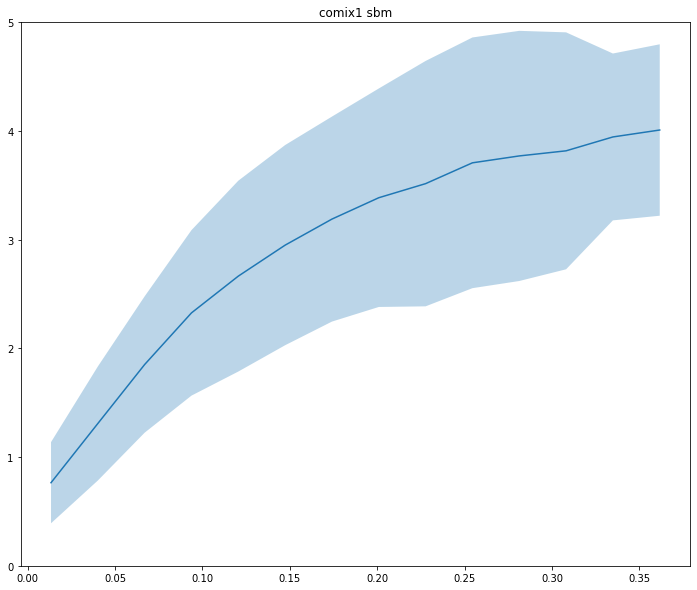

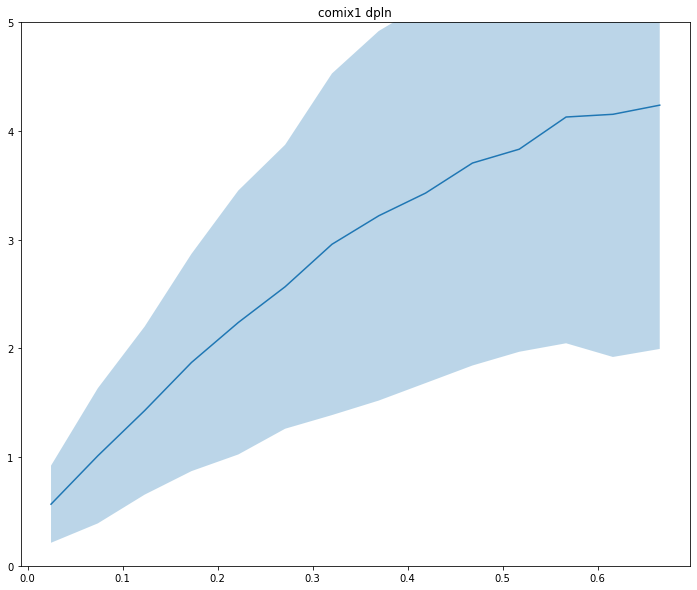

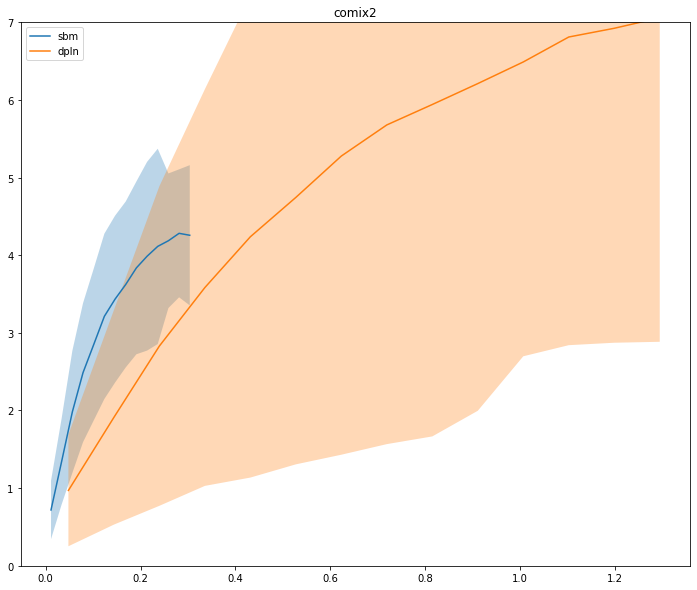

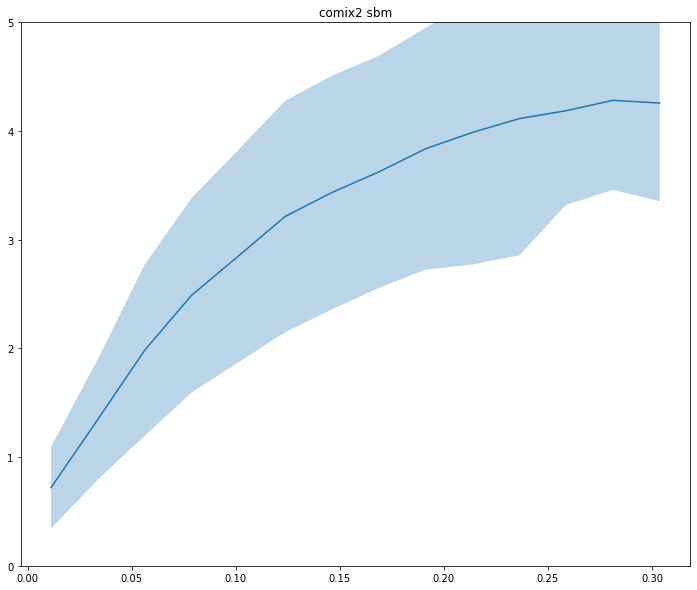

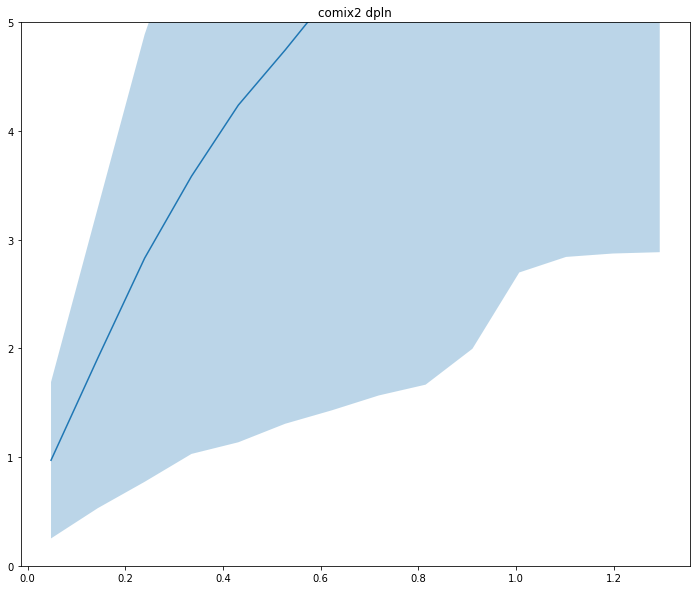

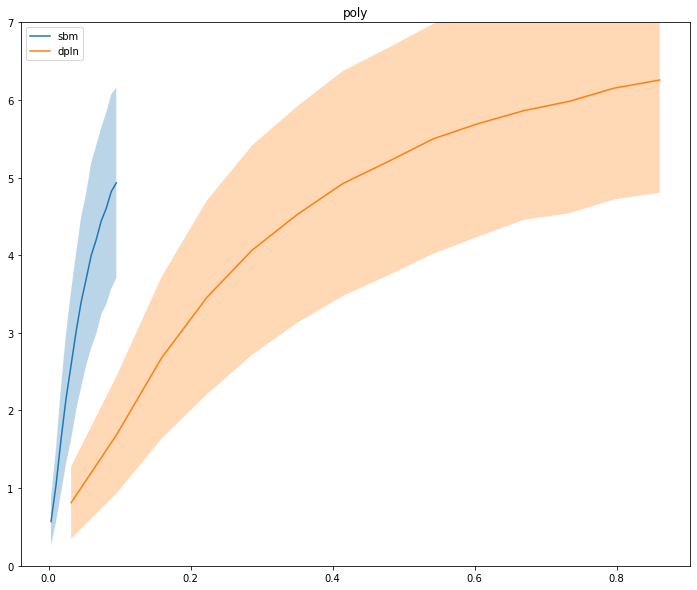

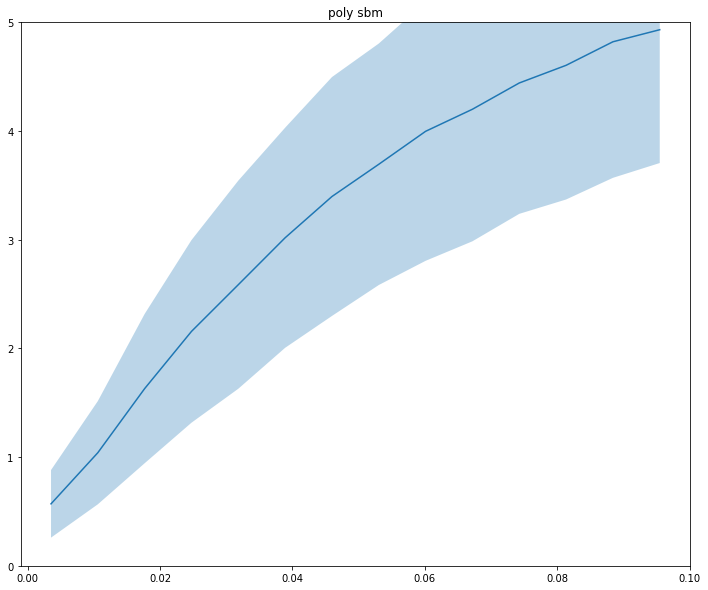

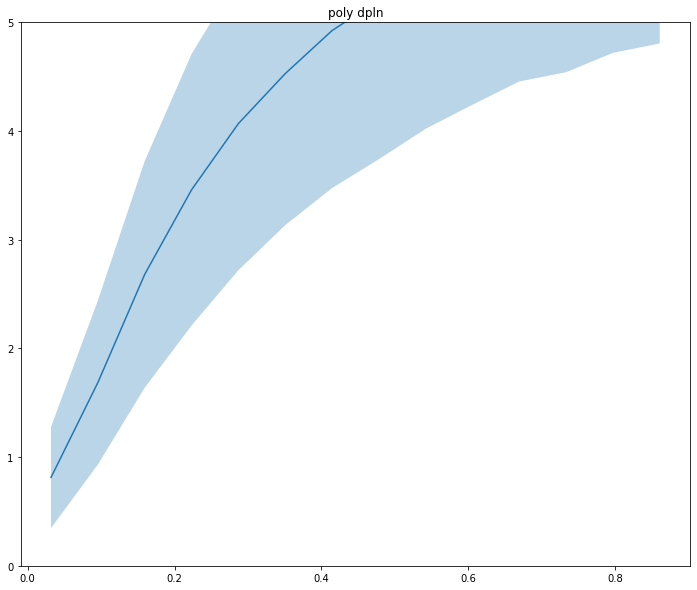

In [5]:
## data preprocessing , many files to one
def sim_idx(sim_num=0, gmm=False):
    if gmm == False:
        if sim_num == 0:
            return 0
        elif sim_num <= 4:
            return 1
        elif sim_num <= 9:
            return 2
        elif sim_num <= 16:
            return 3
        elif sim_num <= 17:
            return 4 
        elif sim_num <= 19:
            return 5
        elif sim_num <= 22:
            return 6
        else:
            return 7
    else:
        return sim_num
############################### no scale ################################
## 0
taus_n0 = [[np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.1,0.0025)]]
## 1,2,3,4
taus_n1 = [[np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.1,0.005)]]
# 5,6,7,8,9
taus_n2 = [[np.arange(0.1,0.205,0.005), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.05,0.2,0.01), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.001,0.1,0.005), np.arange(0.0025,0.05,0.0025)]]
# 10,11,12,13,14,15
taus_n3 = [[np.arange(0.1,0.305,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.05,0.25,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.001,0.1,0.002), np.arange(0.0001,0.04,0.0001)]]
# 17
taus_n4 = [[np.arange(0.28,0.38,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.2,0.32,0.005), np.arange(0.0001,0.002,0.0001)],
        [np.arange(0.001,0.08,0.001), np.arange(0.0001,0.03,0.0001)]]
# 18,19
taus_n5 = [[np.arange(0.005,0.1,0.005), np.arange(0.0005,0.005,0.0005)],
        [np.arange(0.005,0.1,0.005), np.arange(0.00005,0.001,0.00005)],
        [np.arange(0.001,0.05,0.001), np.arange(0.0001,0.03,0.0001)]]
# 20,21,22
taus_n6 = [[np.arange(0.005,0.05,0.005), np.arange(0.0001,0.005,0.0001)],
        [np.arange(0.005,0.05,0.005), np.arange(0.00005,0.001,0.00005)],
        [np.arange(0.001,0.025,0.001), np.arange(0.0005,0.015,0.0005)]]
# 23,24
taus_n7 = [[np.arange(0.1,0.205,0.005), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.05,0.2,0.01), np.arange(0.0005,0.01,0.0005)],
        [np.arange(0.001,0.1,0.005), np.arange(0.0025,0.05,0.0025)]]

taus_n = [taus_n0,taus_n1,taus_n2,taus_n3,taus_n4,taus_n5,taus_n6,taus_n7]

############################### scale ##################################
## 0
taus_s0 = [[np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.06,0.001)],
        [np.arange(0.001,0.1,0.0025), np.arange(0.001,0.1,0.0025)]]
taus_s0 = [[10*x for x in a] for a in taus_s0]
## 1,2,3,4
taus_s1 = [[np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.06,0.002)],
        [np.arange(0.001,0.1,0.005), np.arange(0.001,0.1,0.005)]]
taus_s1 = [[10*x for x in a] for a in taus_s1]
## 5,6,7,8
taus_s2 = [[[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.07,0.002)],
        [[],np.arange(0.001,0.05,0.002)]]
taus_s2 = [[10*x for x in a] for a in taus_s2]
# 10,11,12,13,14,15
taus_s3 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s3 = [[10*x for x in a] for a in taus_s3]
# 17
taus_s4 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s4 = [[15*x for x in a] for a in taus_s4]
# 18,19
taus_s5 = [[[],np.arange(0.005,0.3,0.005)],
        [[],np.arange(0.005,0.4,0.005)],
        [[],np.arange(0.005,0.2,0.005)]]
# 20,21,22
taus_s6 = [[[],np.arange(0.0025,0.1,0.0025)],
        [[],np.arange(0.0025,0.1,0.0025)],
        [[],np.arange(0.0025,0.1,0.0025)]]
# 23
taus_s7 = [[[],np.arange(0.0005,0.01,0.0005)],
        [[],np.arange(0.0005,0.09,0.0005)],
        [[],np.arange(0.0005,0.06,0.0005)]]
taus_s7 = [[15*x for x in a] for a in taus_s7]

taus_s = [taus_s0,taus_s1,taus_s2,taus_s3,taus_s4,taus_s5,taus_s6,taus_s7]

######################################### gmm scale #####################################
## 0
taus_0 = [np.arange(0.0005,0.02,0.0005),
        np.arange(0.0005,0.15,0.0005),
        np.arange(0.0005,0.10,0.0005)]
taus_0 = [[15*x for x in a] for a in taus_0]
## 1 Need to make max larger for scaled (need to move up to 5)
taus_1 = [np.arange(0.0005,0.02,0.0005),
        np.arange(0.0005,0.15,0.0005),
        np.arange(0.0005,0.10,0.0005)]
taus_1 = [[20*x for x in a] for a in taus_1]
## 2 / comix3 0, 85+ used c2 for c3
taus_2 = [np.arange(0.01,0.4,0.01),
        np.arange(0.01,0.6,0.01),
        np.arange(0.01,0.5,0.01)]

taus_gmm_s = [taus_0, taus_1, taus_2]

######################################### gmm no scale #####################################
## 0,1
taus_0 = [np.arange(0.001,0.03,0.001),
        np.arange(0.001,0.03,0.001),
        np.arange(0.005,0.11,0.005)]
## 2 / comix3 0, used c2 from 85
taus_2 = [np.arange(0.0005,0.007,0.0005),
        np.arange(0.0005,0.005,0.0005),
        np.arange(0.002,0.07,0.002)]
taus_gmm_n = [taus_0, taus_0, taus_2]

datas = ['comix1', 'comix2', 'poly']
n=100_000

for data_idx, data in enumerate(datas):
    fig1,ax1 = plt.subplots(1,1,figsize=(12,10))
    for model_idx in range(2):
        fig2,ax2 = plt.subplots(1,1,figsize=(12,10))
        
        # not gmm
        overall = {'r0': [], 'final_size': [], 'peak_height': [], 'beta': []}
        count = 0
        for sim_num in range(37):
            try:
                with open(f'output_data/sims/{sim_num}_{data}_{"sbm_none" if model_idx==0 else "dpln_fit1"}.json', 'r') as f:
                    tmp = json.load(f)
                for tau, tau_sim in enumerate(tmp['r0_1']):    
                    r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                    if r0 == -1: 
                        continue
                    final_sizes = [a/n for a in tmp['final_size'][tau] if a > 0]
                    peak_heights = [a/n for a in tmp['peak_height'][tau] if a > 0]
                    r0s = [a for a in tau_sim if a > 0]
                    overall['r0'].append(r0s); overall['final_size'].append(final_sizes); overall['peak_height'].append(peak_heights); 
                    overall['beta'].append(taus_n[sim_idx(sim_num,False)][data_idx][model_idx][tau] if model_idx==0 else taus_s[sim_idx(sim_num,False)][data_idx][model_idx][tau])
            except: 
                print(data,"sbm" if model_idx==0 else "dpln",sim_num)
        # taus_gmm_n[sim_num][2] = np.arange(0.01,0.4,0.01) if network_num<85 else np.arange(0.01,0.6,0.01)
        
        ###### save data ######
        with open(f'output_data/sims/final/{data}_{"sbm" if model_idx==0 else "dpln"}.json','w') as f:
            json.dump(overall, f)
        ###################### bucket data and make ribbon plots #######################
        bucket_edges = np.linspace(0, max(overall['beta']), 15)
        bucket_centers = (bucket_edges[:-1] + bucket_edges[1:]) / 2

        # Prepare to store means and variances
        means = []
        variances = []

        for start, end in zip(bucket_edges[:-1], bucket_edges[1:]):
            # Find indices of x_values that fall into this bucket
            indices_in_bucket = [i for i, x in enumerate(overall['beta']) if start <= x < end]
            # If no data in this bucket, skip
            if not indices_in_bucket:
                means.append(None)
                variances.append(None)
                continue

            # Get all y_lists in this bucket
            y_lists = [overall['r0'][i] for i in indices_in_bucket]
            bucket_y_lists = []
            for a in y_lists:
                for b in a:
                    bucket_y_lists.append(b)
            # Convert to array to compute stats by column
            y_array = np.array(bucket_y_lists)
            means.append(np.mean(y_array))
            variances.append(np.var(y_array))
            
        ax2.plot(bucket_centers, means)
        ax2.fill_between(bucket_centers,
                            np.array(means) - np.sqrt(variances),
                            np.array(means) + np.sqrt(variances),
                            alpha=0.3)
        ax2.set_title(f'{data} {"sbm" if model_idx==0 else "dpln"}')
        ax2.set_ylim([0,5])
        
        ####################### code for gmm #####################
        
        
        
        ###################### plot all rates ###################
        ax1.plot(bucket_centers, means, label=f'{"sbm" if model_idx==0 else "dpln"}')
        ax1.fill_between(bucket_centers,
                            np.array(means) - np.sqrt(variances),
                            np.array(means) + np.sqrt(variances),
                            alpha=0.3)
    ax1.set_title(f'{data}')
    ax1.set_ylim([0,7])
    ax1.legend()

/tmp/ipykernel_9041/3398289031.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  R = 1 - np.array([sc.optimize.fsolve(R_inf, x0=0.1, args=(r0), xtol=1e-10)[0] if r0 > 1 else 1 for r0 in r0s_ode])
/tmp/ipykernel_9041/3398289031.py:29: RuntimeWarning: invalid value encountered in log
  return (r0*(1-S) + np.log(S))**2


comix1 sbm
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000001, 1.5000000000000002, 1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5000000000000004, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0]
comix1 sbm
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3000000000000003, 1.4000000000000001, 1.5000000000000002, 1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5000000000000004, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0000000000000004, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5000000000000004, 3.6, 3.7, 3.8000000000000003,

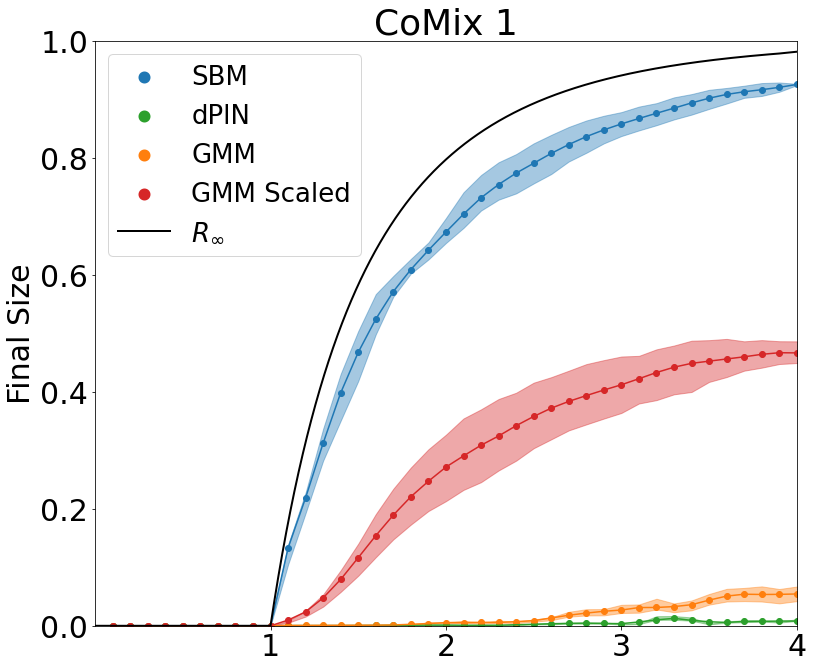

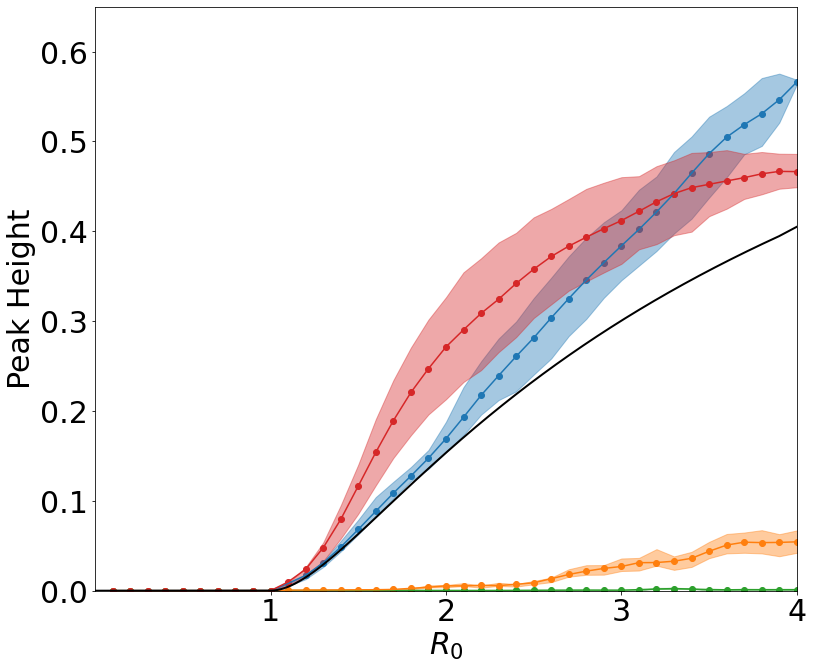

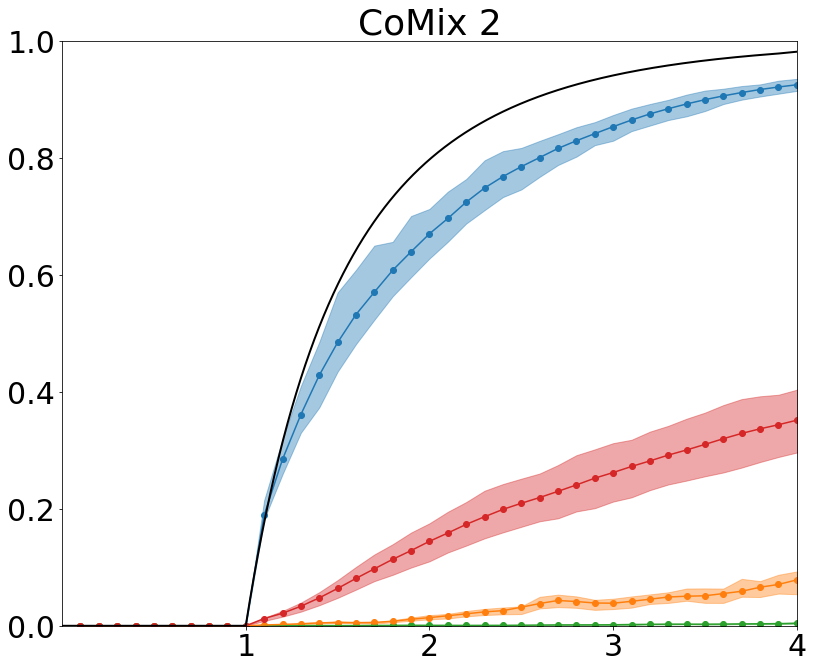

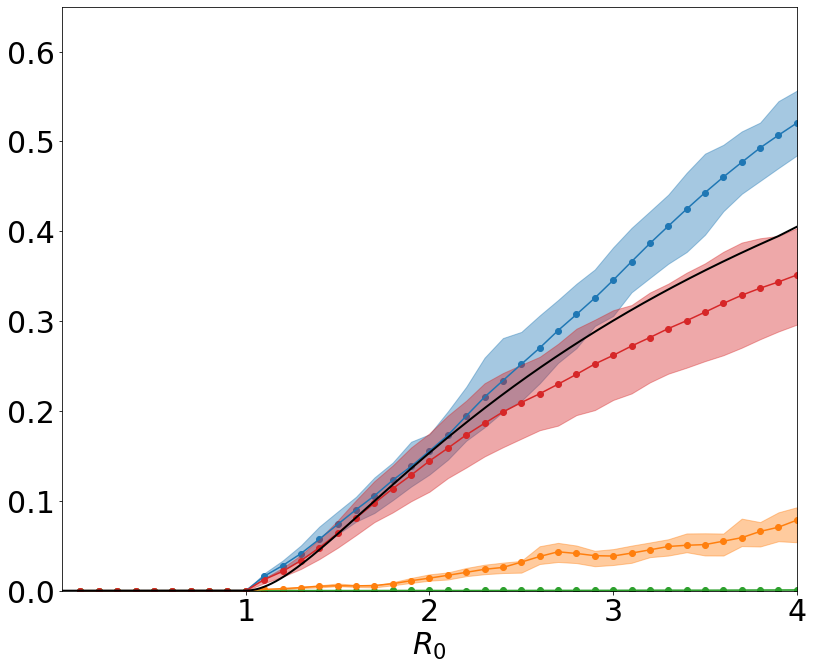

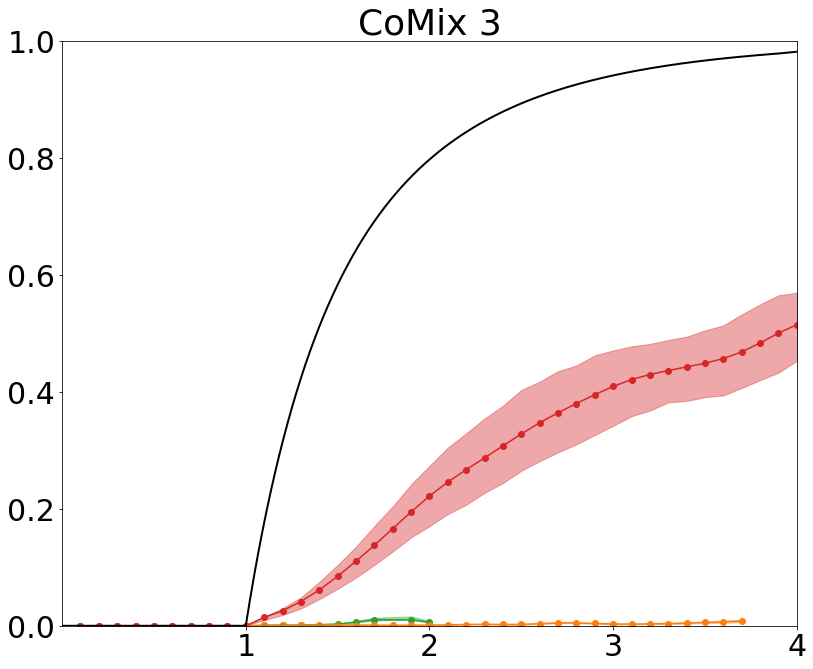

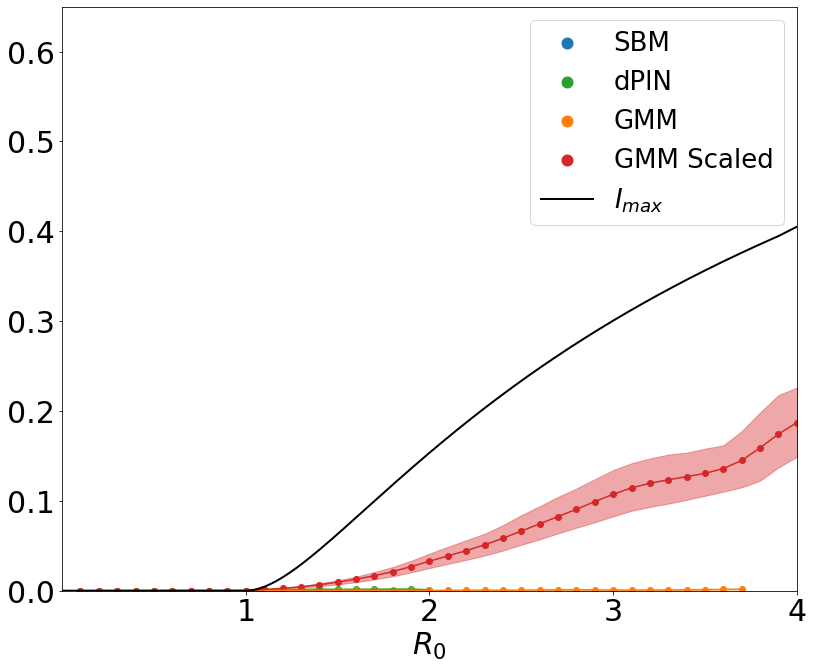

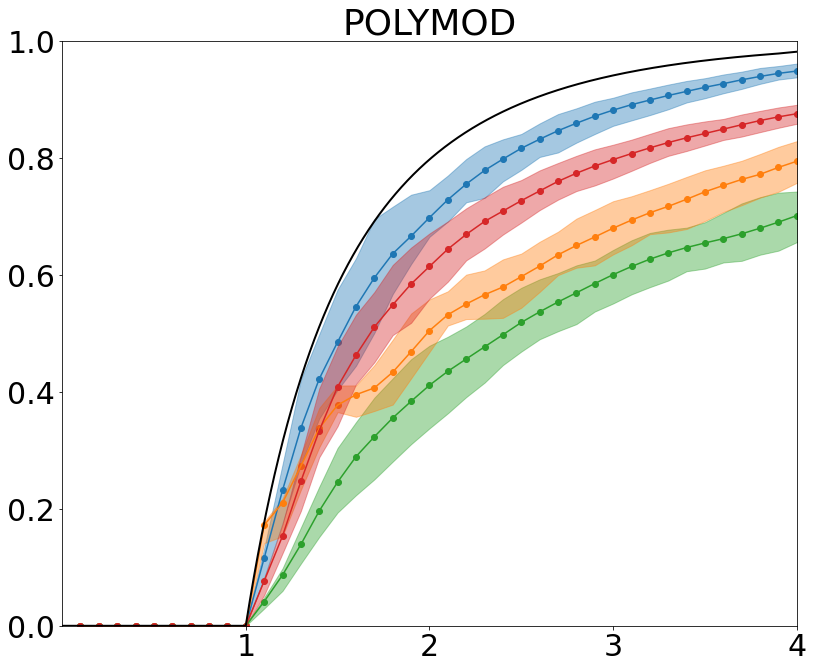

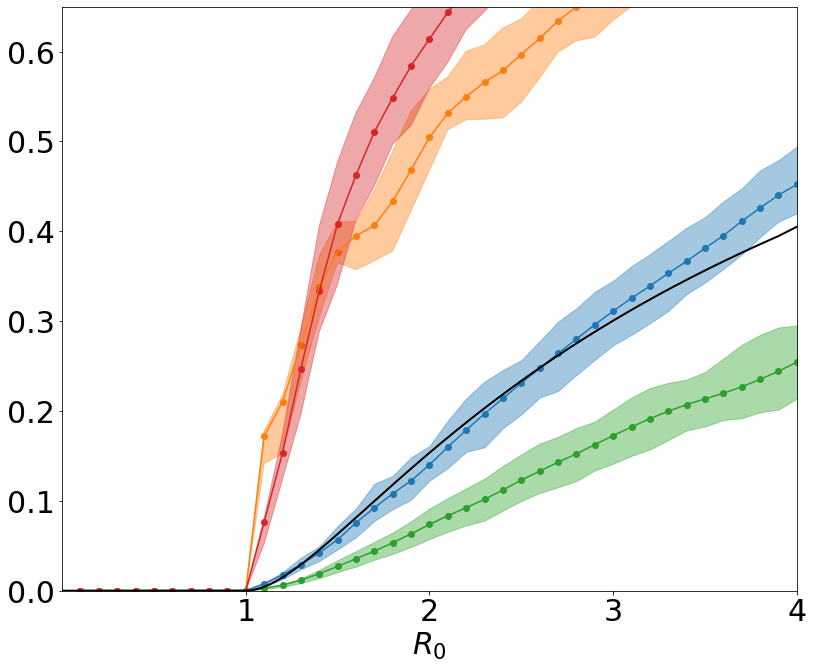

In [15]:
plt.rcParams.update({'font.size': 30})

n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]

datas = ['comix1','comix2','comix3','poly']
data_names = ['CoMix 1', 'CoMix 2', 'CoMix 3', 'POLYMOD']
models = ['sbm','dpln','gmm_none','gmm_scale']
model_names =['SBM', 'dPlN', 'GMM', 'GMM Scaled']

# bins 
top, step = 4.5, 0.10
bins = np.arange(step, top + step, step)
bin_centers = np.array([a/2 if i == 0 else a - (a - bins[i-1])/2 for i,a in enumerate(bins)])
digit = [a for a in bins]; digit.append(1e6)

colours = {models[0]: "tab:blue", models[1]: "tab:green", models[2]: "tab:orange", models[3]: 'tab:red'}

available_colors = [
    'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink',
    'brown', 'black', 'white', 'gray', 'cyan', 'magenta',
    'lime', 'teal', 'navy', 'maroon', 'olive', 'gold', 'silver'
]

n_gmm = 50_000
# ode solutions 
# R_inf
def R_inf(S, r0):
    return (r0*(1-S) + np.log(S))**2

def max_I(r0, S_0=1-10/n, I_0=10/n):
    return I_0 + S_0 + (1/r0)*(np.log(1/r0) - 1 - np.log(S_0))

r0s_ode = np.arange(0,3.9,0.001)

R = 1 - np.array([sc.optimize.fsolve(R_inf, x0=0.1, args=(r0), xtol=1e-10)[0] if r0 > 1 else 1 for r0 in r0s_ode])
peak_I = np.array([max_I(r0) if r0 > 1 else 0 for r0 in r0s_ode])

for i, data in enumerate(datas):
    fig1,ax1 = plt.subplots(1,1,figsize=(12,10))
    fig2,ax2 = plt.subplots(1,1,figsize=(12,10))

    fs_sbm, ph_sbm, r0s_sbm = [[] for _ in bins], [[] for _ in bins], []
    fs_dpln, ph_dpln, r0s_dpln = [[] for _ in bins], [[] for _ in bins], []
    fs_gmm, ph_gmm, r0s_gmm = [[] for _ in bins], [[] for _ in bins], []
    fs_gmms, ph_gmms, r0s_gmms = [[] for _ in bins], [[] for _ in bins], []

    for j, model in enumerate(models):
        
        if j < 2:
            for sim_num in range(37):
                try:
                    with open(f'output_data/sims/{sim_num}_{data}_{model}_none.json', 'r') as f:
                        tmp = json.load(f)
                    for tau, tau_sim in enumerate(tmp['r0_1']):    
                        r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                        if r0 == -1: 
                            continue
                        final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                        peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                        bin_idx = np.digitize(r0, digit, right=False)
                        if bin_idx < len(bins):
                            if j == 0:
                                for k, sims in enumerate(final_sizes):
                                    fs_sbm[bin_idx].append(sims/n)
                                    ph_sbm[bin_idx].append(peak_heights[k]/n)
                                r0s_sbm.append(r0)
                            else:
                                for k, sims in enumerate(final_sizes):
                                    fs_dpln[bin_idx].append(sims/n)
                                    ph_dpln[bin_idx].append(peak_heights[k]/n)
                                r0s_dpln.append(r0)
                except: 
                    a=1
        else:
            for sim_num in range(3):
                for network in range(120):
                    try:
                        with open(f'output_data/gmm/{sim_num}_{network}_{data}_{model}.json','r') as f:
                            tmp = json.load(f)
                        for tau, tau_sim in enumerate(tmp['r0_1']):    
                            r0 = np.mean([a for a in tau_sim if a > 0]) if len([a for a in tau_sim if a > 0]) > 0 else -1
                            if r0 == -1: 
                                continue
                            final_sizes = [a for a in tmp['final_size'][tau] if a > 0]
                            peak_heights = [a for a in tmp['peak_height'][tau] if a > 0]
                            bin_idx = np.digitize(r0, digit, right=False)
                            if bin_idx < len(bins):
                                if j == 2:
                                    for k, sims in enumerate(final_sizes):
                                        fs_gmm[bin_idx].append(sims/n if i==2 else sims/n_gmm)
                                        ph_gmm[bin_idx].append(peak_heights[k]/n if i==2 else sims/n_gmm)
                                    r0s_gmm.append(r0)
                                else:
                                    for k, sims in enumerate(final_sizes):
                                        fs_gmms[bin_idx].append(sims/n if i==2 else sims/n_gmm)
                                        ph_gmms[bin_idx].append(peak_heights[k]/n if i==2 else sims/n_gmm)
                                    r0s_gmms.append(r0)
                    except:
                        a=1
                        
    ########################################################## sbm ############################################################                
    model = models[0]
    if i != 2:
        mean, up, down = [np.mean(a) for a in fs_sbm if len(a)>0], [np.percentile(a, 95) for a in fs_sbm if len(a)>0], [np.percentile(a, 5) for a in fs_sbm if len(a)>0]
        index, tmp = 0, []
        for a in fs_sbm:
            if len(a) > 0:
                tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                index += 1
        fs_sbm = tmp
        mean, up, down = [np.mean(a) for a in fs_sbm if len(a)>0], [np.percentile(a, 95) for a in fs_sbm if len(a)>0], [np.percentile(a, 5) for a in fs_sbm if len(a)>0]
        x = [bins[idx] for idx, a in enumerate(fs_sbm) if len(a)>0]
        
        print(data,model)
        print(x)
        start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
        
        mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
        mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
        mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

        ax1.scatter(x, mean, color=colours[model])
        ax1.plot(x, mean, color=colours[model])
        ax1.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax1.scatter([-1],[-1], label = model_names[0], linewidths=6, color=colours[model])
    
    if i != 2:
        mean, up, down = [np.mean(a) for a in ph_sbm if len(a)>0], [np.percentile(a, 95) for a in ph_sbm if len(a)>0], [np.percentile(a, 5) for a in ph_sbm if len(a)>0]
        index, tmp = 0, []
        for a in ph_sbm:
            if len(a) > 0:
                tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
                index += 1
        ph_sbm = tmp
        mean, up, down = [np.mean(a) for a in ph_sbm if len(a)>0], [np.percentile(a, 95) for a in ph_sbm if len(a)>0], [np.percentile(a, 5) for a in ph_sbm if len(a)>0]
        x = [bins[idx] for idx, a in enumerate(ph_sbm) if len(a)>0]
        
        print(data,model)
        print(x)
        start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
        
        mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
        mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
        mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

        ax2.scatter(x, mean, color=colours[model])
        ax2.plot(x, mean, color=colours[model])
        ax2.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax2.scatter([-1],[-1], label = model_names[0], linewidths=6, color=colours[model])
    
    ########################################################## dpln ############################################################ 
    model = models[1]               
    mean, up, down = [np.mean(a) for a in fs_dpln if len(a)>0], [np.percentile(a, 95) for a in fs_dpln if len(a)>0], [np.percentile(a, 5) for a in fs_dpln if len(a)>0]
    index, tmp = 0, []
    for a in fs_dpln:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    fs_dpln = tmp
    mean, up, down = [np.mean(a) for a in fs_dpln if len(a)>0], [np.percentile(a, 95) for a in fs_dpln if len(a)>0], [np.percentile(a, 5) for a in fs_dpln if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(fs_dpln) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax1.scatter(x, mean, color=colours[model])
    ax1.plot(x, mean, color=colours[model])
    ax1.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax1.scatter([-1],[-1], label = model_names[1], linewidths=6, color=colours[model])
    
    mean, up, down = [np.mean(a) for a in ph_dpln if len(a)>0], [np.percentile(a, 95) for a in ph_dpln if len(a)>0], [np.percentile(a, 5) for a in ph_dpln if len(a)>0]
    index, tmp = 0, []
    for a in ph_dpln:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    ph_dpln = tmp
    mean, up, down = [np.mean(a) for a in ph_dpln if len(a)>0], [np.percentile(a, 95) for a in ph_dpln if len(a)>0], [np.percentile(a, 5) for a in ph_dpln if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(ph_dpln) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax2.scatter(x, mean, color=colours[model])
    ax2.plot(x, mean, color=colours[model])
    ax2.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax2.scatter([-1],[-1], label = model_names[1], linewidths=6, color=colours[model])
    
    ########################################################## gmm ############################################################ 
    model = models[2]               
    mean, up, down = [np.mean(a) for a in fs_gmm if len(a)>0], [np.percentile(a, 95) for a in fs_gmm if len(a)>0], [np.percentile(a, 5) for a in fs_gmm if len(a)>0]
    index, tmp = 0, []
    for a in fs_gmm:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    fs_gmm = tmp
    mean, up, down = [np.mean(a) for a in fs_gmm if len(a)>0], [np.percentile(a, 95) for a in fs_gmm if len(a)>0], [np.percentile(a, 5) for a in fs_gmm if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(fs_gmm) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax1.scatter(x, mean, color=colours[model])
    ax1.plot(x, mean, color=colours[model])
    ax1.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax1.scatter([-1],[-1], label = model_names[2], linewidths=6, color=colours[model])
                  
    mean, up, down = [np.mean(a) for a in ph_gmm if len(a)>0], [np.percentile(a, 95) for a in ph_gmm if len(a)>0], [np.percentile(a, 5) for a in ph_gmm if len(a)>0]
    index, tmp = 0, []
    for a in ph_gmm:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    ph_gmm = tmp
    mean, up, down = [np.mean(a) for a in ph_gmm if len(a)>0], [np.percentile(a, 95) for a in ph_gmm if len(a)>0], [np.percentile(a, 5) for a in ph_gmm if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(ph_gmm) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax2.scatter(x, mean, color=colours[model])
    ax2.plot(x, mean, color=colours[model])
    ax2.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax2.scatter([-1],[-1], label = model_names[2], linewidths=6, color=colours[model])
        
    ########################################################## gmms ############################################################ 
    model = models[3]               
    mean, up, down = [np.mean(a) for a in fs_gmms if len(a)>0], [np.percentile(a, 95) for a in fs_gmms if len(a)>0], [np.percentile(a, 5) for a in fs_gmms if len(a)>0]
    index, tmp = 0, []
    for a in fs_gmms:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    fs_gmms = tmp
    mean, up, down = [np.mean(a) for a in fs_gmms if len(a)>0], [np.percentile(a, 95) for a in fs_gmms if len(a)>0], [np.percentile(a, 5) for a in fs_gmms if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(fs_gmms) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax1.scatter(x, mean, color=colours[model])
    ax1.plot(x, mean, color=colours[model])
    ax1.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax1.scatter([-1],[-1], label = model_names[3], linewidths=6, color=colours[model])
    
    mean, up, down = [np.mean(a) for a in ph_gmms if len(a)>0], [np.percentile(a, 95) for a in ph_gmms if len(a)>0], [np.percentile(a, 5) for a in ph_gmms if len(a)>0]
    index, tmp = 0, []
    for a in ph_gmms:
        if len(a) > 0:
            tmp.append([b for b in a if b/mean[index] > 1/1.33 and b/mean[index] < 1.33])
            index += 1
    ph_gmms = tmp
    mean, up, down = [np.mean(a) for a in ph_gmms if len(a)>0], [np.percentile(a, 95) for a in ph_gmms if len(a)>0], [np.percentile(a, 5) for a in ph_gmms if len(a)>0]
    x = [bins[idx] for idx, a in enumerate(ph_gmms) if len(a)>0]
    
    # print(data,model)
    # print(x)
    start, end = [1 if a >= 1 else 0 for a in x].index(1), len(x)
    
    mean = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)]
    mean, up, down = [a if idx in [start,end-1] else a  if idx<start else (mean[idx-1]+a+mean[idx+1])/3 for idx, a in enumerate(mean)], [a if idx in [start,end-1] else a  if idx<start else (down[idx-1]+a+down[idx+1])/3 for idx, a in enumerate(down)], [a if i in [start,end-1] else a if i<start else (up[i-1]+a+up[i+1])/3 for i, a in enumerate(up)]        
    mean, up, down = [a if idx >= start + 1 else 0 for idx, a in enumerate(mean)], [a if idx >= start + 1 else 0 for idx, a in enumerate(up)], [a if idx >= start + 1 else 0 for idx, a in enumerate(down)]

    ax2.scatter(x, mean, color=colours[model])
    ax2.plot(x, mean, color=colours[model])
    ax2.fill_between(x, down,up, alpha = 0.4, color=colours[model])
    ax2.scatter([-1],[-1], label = model_names[3], linewidths=6, color=colours[model])
    
    ########################################################### Plot details ##################################################
    
    r0s_ode = list(r0s_ode); R = list(R); peak_I = list(peak_I) 
    r0s_ode.append(4)
    peak_I.append(0.405)
    R.append(0.981)

    ax1.plot(r0s_ode,R,'k',label = r'$R_\infty$', linewidth=2)
    ax1.set_title(f'{data_names[i]}')
    ax1.set_ylabel('Final Size')
    ax1.set_xlim([0,4])
    ax1.set_ylim([0,1])
    if i == 0:
        ax1.legend(prop={'size': 26})
    if i != 0:
        ax1.set_ylabel('')
    ax1.set_xticks([1,2,3,4])
    
    fig1.tight_layout()
    fig1.savefig(f'output_data/figs/fs_{data}.pdf')
    # fig1.show()
    
    ax2.plot(r0s_ode, peak_I,'k',label = r'$I_{max}$', linewidth=2)
    ax2.set_title(f'')
    ax2.set_ylabel('Peak Height')
    ax2.set_xlim([0,4])
    ax2.set_ylim([0,0.65])
    if i == 2:
        ax2.legend(prop={'size':26})
    if i != 0:
        ax2.set_ylabel('')
    ax2.set_xlabel(r'$R_0$')
    ax2.set_xticks([1,2,3,4])
    
    fig2.tight_layout()
    # fig2.savefig(f'ph_{data}_dots.pdf')
    # fig2.show() 

## Secondary Case Distributions

### Helper Functions

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import nbinom
def log_bins(x, num_bins=5):
    """
    Returns log bins of contacts, A^m
    Input: Contacts -> np array, num_bins -> int
    Output: Geometric center of bins -> ndarray, values in bins -> ndarray
    """
    count_zeros = np.sum([1 if a == 0 else 0 for a in x])
    x = np.sort([a for a in x if a > 0])
    max1, min1 = np.log(np.ceil(max(x))), np.log(np.floor(min(x)))
    x = np.log(x)
    t, freq, ends = np.zeros(num_bins), np.zeros(num_bins), np.zeros((2,num_bins))
    step = (max1 - min1)/num_bins
    for val in x:
        for k in range(num_bins):
            if k*step + min1 <= val and val < (k+1)*step + min1:
                freq[k] += 1
            t[k] = (k+1)*step - (.5*step) + min1
            ends[0,k] = k*step + min1
            ends[1,k] = (k+1)*step + min1
    freq[0] += count_zeros
    ends = np.exp(ends)
    widths = ends[1] - ends[0]
    freq = freq/widths/(len(x)+count_zeros)
    # freq = 1/np.sqrt(freq)*freq
    midpoints = np.exp(t)
    return midpoints, freq

def log_bins_from_a(x, min_val=5, num_bins=5):
    """
    Returns log bins of contacts, A^m
    Input: Contacts -> np array, num_bins -> int
    Output: Geometric center of bins -> ndarray, values in bins -> ndarray
    """
    start = len(x)
    # count_zeros = np.sum(x[x==0])
    count_zeros = sum([1 if a==0 else 0 for a in x])
    x_under_a = np.sort([a for a in x if a <= min_val])
    x = np.sort([a for a in x if a > 0])
    count_under_a = sum([1 if a<=min_val else 0 for a in x])
    x = np.sort([a for a in x if a > min_val])
    # print(f'all = {start}, {len(x) + count_zeros + count_under_a}')
    max1, min1 = np.log(np.ceil(max(x))), np.log(np.floor(min(x)))
    x = np.log(x)
    t, freq, ends = np.zeros(num_bins), np.zeros(num_bins), np.zeros((2,num_bins))
    step = (max1 - min1)/num_bins
    for val in x:
        for k in range(num_bins):
            if k*step + min1 <= val and val < (k+1)*step + min1:
                freq[k] += 1
            t[k] = (k+1)*step - (.5*step) + min1
            ends[0,k] = k*step + min1
            ends[1,k] = (k+1)*step + min1
    # freq[0] += count_zeros
    ends = np.exp(ends)
    widths = ends[1] - ends[0]
    freq = freq/widths/(len(x)+count_zeros + count_under_a)
    # freq = 1/np.sqrt(freq)*freq
    midpoints = np.exp(t)
    
    midpoints_ua = np.arange(min_val+1)
    freq_ua = np.zeros(min_val+1)
    for val in x_under_a:
        freq_ua[val] += 1
    freq = np.concatenate((freq_ua/(len(x)+count_zeros+count_under_a), freq))
    midpoints = np.concatenate((midpoints_ua, midpoints))
    return midpoints, freq

def log_likelihood_nbinom(params, contacts):
    r, p = params
    log_likelihood = nbinom.logpmf(contacts, r, p)
    return -np.sum(log_likelihood)

def log_likelihood_nbinom_mean(params, contacts,r0):
    r = params
    p = r/(r+r0)
    log_likelihood = nbinom.logpmf(contacts, r, p)
    return -np.sum(log_likelihood)

### Make figs

#### dpln


sbm k = 0.8732219268853182

80% of cases caused by 0.3986408017549142% of people

dpln k = 0.042607368094944045

80% of cases caused by 0.05504587155963303% of people


scale k = 0.468286995002449

80% of cases caused by 0.2878584132217065% of people


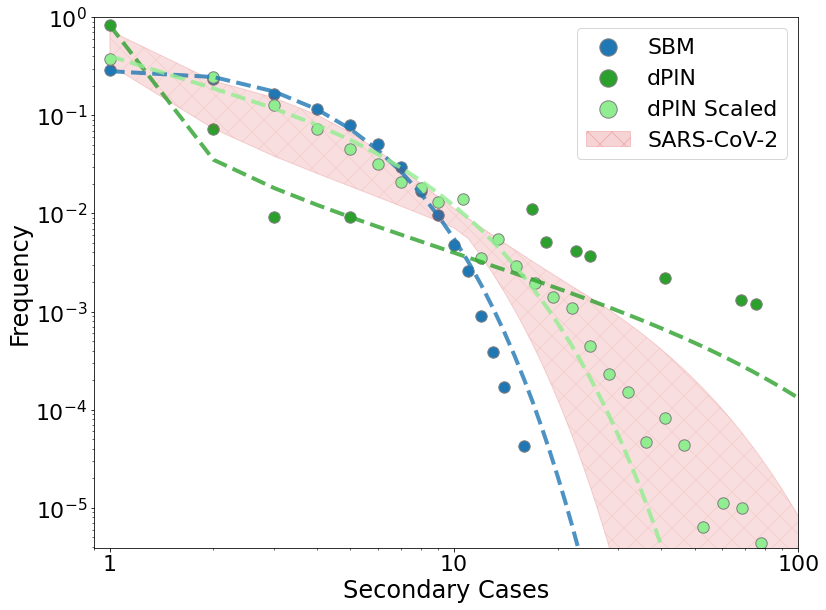


sbm k = 0.7936129637633078

80% of cases caused by 0.3836989247311828% of people

dpln k = 0.07317132973912331

80% of cases caused by 0.06911385144823631% of people


scale k = 0.36261041360025537

80% of cases caused by 0.24085689045936395% of people


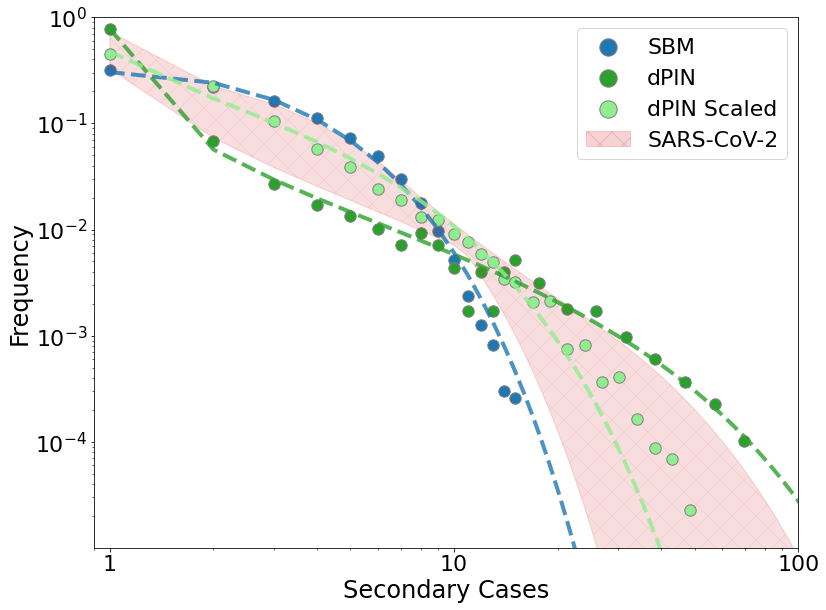


sbm k = 0.7403219948938176

80% of cases caused by 0.37267294380669846% of people

dpln k = 0.46485908982168256

80% of cases caused by 0.28996074032529445% of people


scale k = 0.6494673607328608

80% of cases caused by 0.3503611747912972% of people


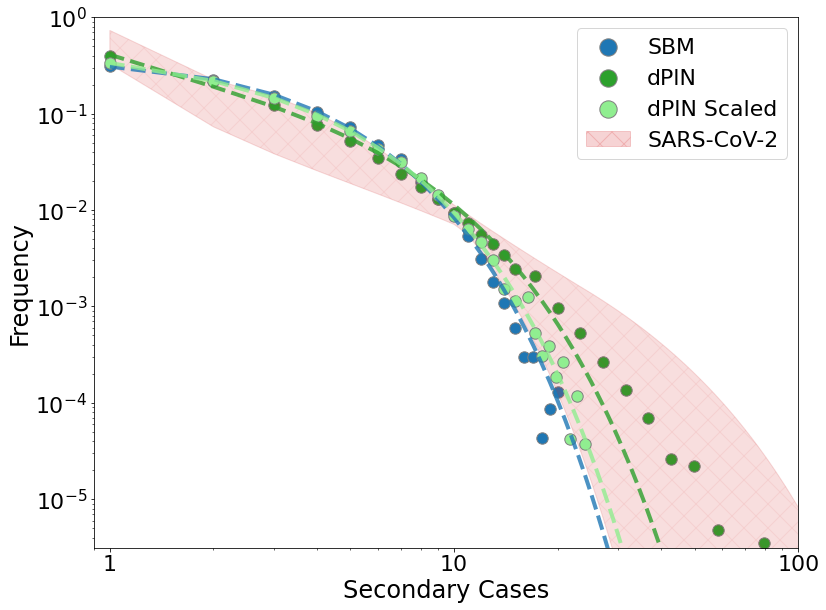

In [4]:
from scipy.stats import nbinom
from scipy.optimize import minimize
#### do this ########
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
plt.rcParams.update({'font.size': 24})

datas = ['comix1','comix2','poly']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
models = ['sbm','dpln','scale']
model_names =['SBM', 'dPlN', 'Scaled']
scales_n = ['none']
scales_s = ['fit1', 'fit2']
R0s = [2,2.5,3]

for i, data in enumerate(datas):
    for R0_idx in range(3):
        if R0_idx != 0: 
            continue
        # fig1,ax1 = plt.subplots(1,1,figsize=(12,10))
        # fig2,ax2 = plt.subplots(1,1,figsize=(12,10))
        fig3,ax3 = plt.subplots(1,1,figsize=(12,9))
        
        max_x, max_y = 0,0
        min_x, min_y = 1,1
        for j, model in enumerate(models):
            r01, sc1 = [], []
            for sim_num in range(12):
                try:
                    if j == 2:
                        with open(f'output_data/sims/{sim_num}_{data}_{models[1]}_fit1_sc.json','r') as f:
                            sc_main = json.load(f)
                    else:
                        with open(f'output_data/sims/{sim_num}_{data}_{model}_none_sc.json','r') as f:
                            sc_main = json.load(f)
                    for val in sc_main['r0_1'][R0_idx]:
                        r01.append(val)
                    if sim_num > 4:
                        for val in sc_main['secondary_cases1'][R0_idx]:
                            sc1.append(val)
                    else:
                        for val in sc_main['secondary_cases'][R0_idx]:
                            sc1.append(val)
                except:
                    print(f'')
            if len(sc1) == 0:
                print(f'no data {data} {model}')
                continue
            if i == 0:
                min_val, num_bins = 8,17
            else:
                min_val, num_bins = 14,11
            # min_val, num_bins = 5,5
            
            if j == 0:
                colour = 'tab:blue'
            elif j == 2:
                colour = 'lightgreen'
            else:
                colour = 'tab:green'
            
            if j >= 1:    
                # print(f'here {len(sc1)}')
                xs,ys = log_bins_from_a(sc1, min_val=min_val, num_bins=num_bins)
                xs, ys = np.array([x+1 for i, x in enumerate(xs) if ys[i] > 0]), np.array([y for y in ys if y > 0])
                if max_x < max(xs):
                    max_x = max(xs)
                if min_x > min(xs):
                    min_x = min(xs)
                if max_y < max([a for a in ys if a > 0]):
                    max_y = max([a for a in ys if a > 0])
                if min_y > min([a for a in ys if a > 0]):
                    min_y = min([a for a in ys if a > 0])
            # non binned
            y,x = np.histogram(sc1, bins=np.arange(max(sc1) + 1), density=True)
            
            # change legend , fit to nb , add labels
            result = minimize(log_likelihood_nbinom, x0=[1, 0.5], args=(sc1), method='Nelder-Mead')
            x_fit = np.arange(0, max(sc1)+200)
            # print(result.x)
            # if j ==1 or j==0:
            #     print(f'no scale')
            # else:
            #     print(f'scale')
            # if j!=0:
            print(f'{model} k = {result.x[0]*(1-result.x[1])}\n')
            # print(f'here: ')

            tmp_sort = sorted(sc1,reverse=True)
            total = sum(sc1)
            cumsum, count = 0, 0
            for value in tmp_sort:
                cumsum += value
                count += 1
                # Stop once we reach 80% of the total sum
                if cumsum >= 0.8 * total:
                    break
    
            print(f'80% of cases caused by {count/len(tmp_sort)}% of people')
            
            pmf_nbinom = nbinom.pmf(x_fit, result.x[0], result.x[1])
            
             
            x_pois = np.arange(0,max(x))
            # pmf_pois = sc_main.stats.poisson.pmf(x_pois, 3)
            k_cov = 0.4
            p = k_cov/R0s[R0_idx]
            # dfTeX error: pdflatex (file ./figs/contact matrices/cmfinal_CoMix 1_sbm.pdf): xpdf: reading PDF image failedp = k_cov/R0s[R0_idx]
            pmf_cov = nbinom.pmf(x_fit, k_cov/(1-p), p)
            # if j == 1:
            #     # ax1.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            #     # p5,=ax1.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            #     ax3.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            #     p52,=ax3.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            # if j == 2:
                # ax2.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
                # p51,=ax2.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
                # ax3.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
                # p52,=ax3.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            
            pmfs = []
            for k_cov in np.arange(0.1,0.7,0.01):
                p = k_cov/R0s[R0_idx]
                pmfs.append(nbinom.pmf(x_fit, k_cov/(1-p), p))
                # p5,=ax1.plot(x_fit+1, pmfs[-1], 'tab:red', linewidth=0.1)
            upper,lower= [],[]
            for index in range(len(pmfs[0])):
                upper.append(max([a[index] for a in pmfs]))
                lower.append(min([a[index] for a in pmfs]))
            if j == 1:
                # ax1.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
                ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red')
            if j == 2:
                ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
                # ax3.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
                # ax2.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
                
            if j == 0:
                # ax1.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                # p3,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
                # ax2.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                # p31,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
                with open(f'output_data/figs/sc_{data}_sbm.json', 'w') as f:
                    json.dump({'x':[float(a) for a in x[1:]], 'y': [float(a) for a in y], 'xfit': [float(a) for a in x_fit+1], 'pmf': [float(a) for a in pmf_nbinom]}, f)
                ax3.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
                ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="SBM")
                p32,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                # poisson example 
            else:
                if j == 1:
                    # ax1.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    # p4,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="dPlN", c=colour)
                    ax3.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN")
                    p42,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                    
                if j == 2:
                    # ax2.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    # p41,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="dPlN Scaled", c=colour)
                    ax3.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="dPlN Scaled")
                    ax3.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                    p42,=ax3.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
               
            if j == 2:
                # ax3.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
                ax3.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
            
        ax3.set_yscale('log')    
        ax3.set_xscale('log')    
        ax3.set_xlabel('Secondary Cases')
        ax3.set_ylabel('Frequency')

        ax3.set_ylim([min_y*.9, 1])
        # ax3.set_xlim([0.9,max_x*1.1])
        ax3.set_xlim([0.9,100])
        # ax3.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-])
        ax3.set_xticks([1,10,100],[1,10,100])
        
        # ax3.set_title(f'{data}: $R_0$ {R0s[R0_idx]}')
        ax3.legend(prop={'size':22})
        ax3.tick_params(axis='both', which='major', labelsize=22)
        ax3.tick_params(axis='both', which='minor', labelsize=22)
        fig3.tight_layout()
        plt.show()
        # fig3.savefig(f'../output_data/secondary_cases/scfinal_{data}_{model}_{R0s[R0_idx]}.pdf')

#### GMM

In [8]:
with open(f'output_data/gmm/0_8_poly_gmm_scale_sc.json','r') as f:
    res = json.load(f)
print(len(res['r0_1'][0]), len([a for a in res['r0_1'][0] if a > 0]), len(res['secondary_cases'][0]))

48 19 190


comix1 gmm 0 36
comix1 gmm 0 42
comix1 gmm 0 65
comix1 gmm 0 66
comix1 gmm 0 67
comix1 gmm 0 68
comix1 gmm 0 69
comix1 gmm 0 70
comix1 gmm 0 71
comix1 gmm 0 72
comix1 gmm 0 73
comix1 gmm 0 74
comix1 gmm 0 75
comix1 gmm 0 76
comix1 gmm 0 77
comix1 gmm 0 78
comix1 gmm 0 79
comix1 gmm 0 80
comix1 gmm 0 81
comix1 gmm 0 82
comix1 gmm 0 83
comix1 gmm 0 84
comix1 gmm 0 85
comix1 gmm 0 86
comix1 gmm 0 87
comix1 gmm 0 88
comix1 gmm 0 89
comix1 gmm 0 90
comix1 gmm 0 91
comix1 gmm 0 92
comix1 gmm 0 93
comix1 gmm 0 94
comix1 gmm 0 95
comix1 gmm 0 96
comix1 gmm 0 97
comix1 gmm 0 98
comix1 gmm 0 99
comix1 gmm 0 100
comix1 gmm 0 101
comix1 gmm 0 102
comix1 gmm 0 103
comix1 gmm 0 104
comix1 gmm 0 105
comix1 gmm 0 106
comix1 gmm 0 107
comix1 gmm 0 108
comix1 gmm 0 109
comix1 gmm 0 110
comix1 gmm 0 111
comix1 gmm 0 112
comix1 gmm 0 113
comix1 gmm 0 114
comix1 gmm 0 115
comix1 gmm 0 116
comix1 gmm 0 117
comix1 gmm 0 118
comix1 gmm 0 119
comix1 gmm 1 52
comix1 gmm 1 100
comix1 gmm 1 101
comix1 gmm 1 102
c

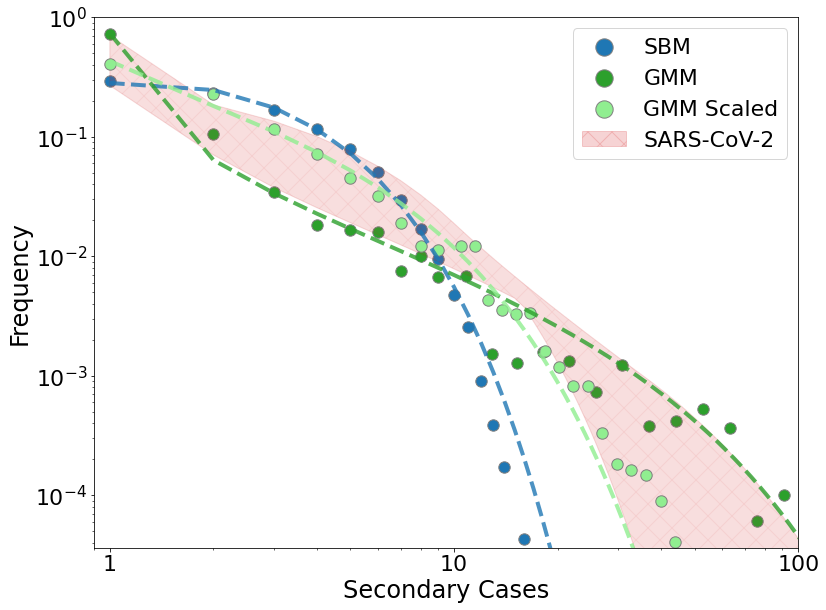

comix2 gmm 0 7
comix2 gmm 0 10
comix2 gmm 0 11
comix2 gmm 0 24
comix2 gmm 0 30
comix2 gmm 0 33
comix2 gmm 0 44
comix2 gmm 0 46
comix2 gmm 0 59
comix2 gmm 0 60
comix2 gmm 0 65
comix2 gmm 0 66
comix2 gmm 0 67
comix2 gmm 0 68
comix2 gmm 0 69
comix2 gmm 0 70
comix2 gmm 0 71
comix2 gmm 0 72
comix2 gmm 0 73
comix2 gmm 0 74
comix2 gmm 0 75
comix2 gmm 0 76
comix2 gmm 0 77
comix2 gmm 0 78
comix2 gmm 0 79
comix2 gmm 0 80
comix2 gmm 0 81
comix2 gmm 0 82
comix2 gmm 0 83
comix2 gmm 0 84
comix2 gmm 0 85
comix2 gmm 0 86
comix2 gmm 0 87
comix2 gmm 0 88
comix2 gmm 0 89
comix2 gmm 0 90
comix2 gmm 0 91
comix2 gmm 0 92
comix2 gmm 0 93
comix2 gmm 0 94
comix2 gmm 0 95
comix2 gmm 0 96
comix2 gmm 0 97
comix2 gmm 0 98
comix2 gmm 0 99
comix2 gmm 0 100
comix2 gmm 0 101
comix2 gmm 0 102
comix2 gmm 0 103
comix2 gmm 0 104
comix2 gmm 0 105
comix2 gmm 0 106
comix2 gmm 0 107
comix2 gmm 0 108
comix2 gmm 0 109
comix2 gmm 0 110
comix2 gmm 0 111
comix2 gmm 0 112
comix2 gmm 0 113
comix2 gmm 0 114
comix2 gmm 0 115
comix2 gm

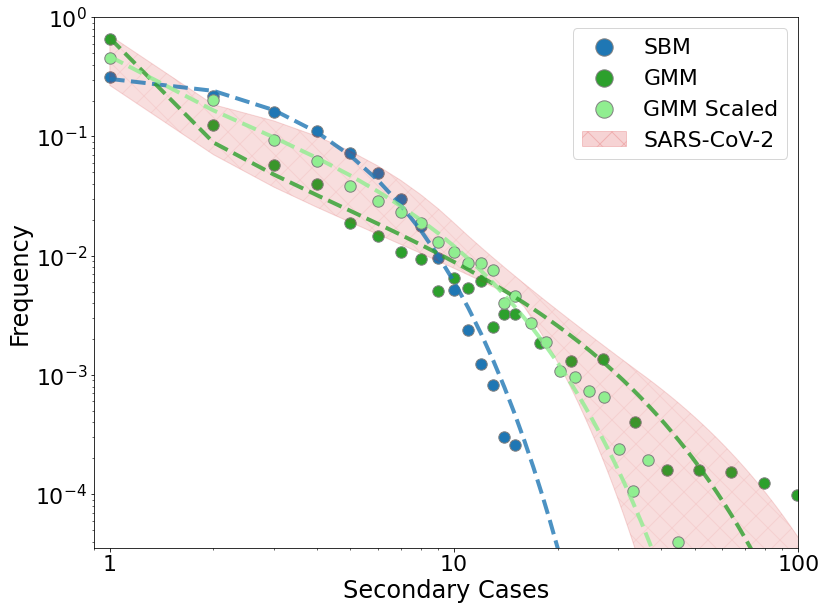

poly gmm 0 65
poly gmm 0 66
poly gmm 0 67
poly gmm 0 68
poly gmm 0 69
poly gmm 0 70
poly gmm 0 71
poly gmm 0 72
poly gmm 0 73
poly gmm 0 74
poly gmm 0 75
poly gmm 0 76
poly gmm 0 77
poly gmm 0 78
poly gmm 0 79
poly gmm 0 80
poly gmm 0 81
poly gmm 0 82
poly gmm 0 83
poly gmm 0 84
poly gmm 0 85
poly gmm 0 86
poly gmm 0 87
poly gmm 0 88
poly gmm 0 89
poly gmm 0 90
poly gmm 0 91
poly gmm 0 92
poly gmm 0 93
poly gmm 0 94
poly gmm 0 95
poly gmm 0 96
poly gmm 0 97
poly gmm 0 98
poly gmm 0 99
poly gmm 0 100
poly gmm 0 101
poly gmm 0 102
poly gmm 0 103
poly gmm 0 104
poly gmm 0 105
poly gmm 0 106
poly gmm 0 107
poly gmm 0 108
poly gmm 0 109
poly gmm 0 110
poly gmm 0 111
poly gmm 0 112
poly gmm 0 113
poly gmm 0 114
poly gmm 0 115
poly gmm 0 116
poly gmm 0 117
poly gmm 0 118
poly gmm 0 119
poly gmm 1 100
poly gmm 1 101
poly gmm 1 102
poly gmm 1 103
poly gmm 1 104
poly gmm 1 105
poly gmm 1 106
poly gmm 1 107
poly gmm 1 108
poly gmm 1 109
poly gmm 1 110
poly gmm 1 111
poly gmm 1 112
poly gmm 1 113


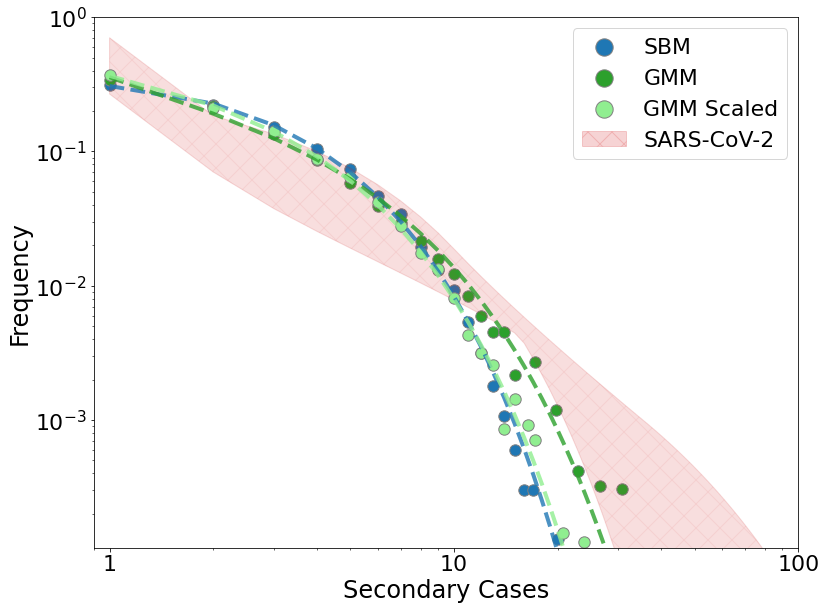

In [17]:
from scipy.stats import nbinom
from scipy.optimize import minimize
#### do this ########
n = 100_000
partitions = [0.058*n, 0.145*n, 0.212*n, 0.364*n, 0.497*n, 0.623*n, 0.759*n, 0.866*n, n]
plt.rcParams.update({'font.size': 24})

datas = ['comix1','comix2','poly']
data_names = ['CoMix 1', 'CoMix 2', 'POLYMOD']
models = ['sbm','gmm','gmm_scale']
model_names =['SBM', 'GMM', 'GMM Scaled']
scales_n = ['none']
scales_s = ['scale']
# R0s = [2,2.5,3]

for i, data in enumerate(datas):
    fig,ax = plt.subplots(1,1,figsize=(12,9))
    for j, model in enumerate(models):
        r0, sc = [], []
        max_x, max_y = 0,0
        min_x, min_y = 1,1
        for param_set in [0,1]:
            for network_num in range(120):
                try:
                    if model == 'sbm':
                        if network_num == 0 and param_set == 0:
                            with open(f'output_data/figs/sc_{data}_sbm.json','r') as f:
                                xy = json.load(f)
                            ax.scatter(xy['x'],xy['y'], s=130,edgecolors='grey', c='tab:blue')
                            ax.scatter([-1],[-1],s=300,edgecolors='grey',c='tab:blue',label="SBM")
                            p32,=ax.plot(xy['xfit'], xy['pmf'], linestyle='--', lw=4,alpha=0.8, c='tab:blue')
                            continue
                        else:
                            continue
                    else:
                        with open(f'output_data/gmm/{param_set}_{network_num}_{data}_{model}_sc.json','r') as f:
                            res = json.load(f)
                    for index, x in enumerate(res['r0_1'][0]):
                        if x >= 0:
                            r0.append(x)
                            sc.append(res['secondary_cases'][0][index])
                except:
                    print(f'{data} {model} {param_set} {network_num}')
                    x=1
        if model == 'sbm':
            continue
        if len(sc) == 0:
            print(f'no data {data} {model}')
            continue
        if i == 0:
            min_val, num_bins = 8,17
        else:
            min_val, num_bins = 14,11
        # min_val, num_bins = 5,5
        
        if j == 0:
            colour = 'tab:blue'
        elif j == 2:
            colour = 'lightgreen'
        else:
            colour = 'tab:green'
        
        if j >= 1:    
            # print(f'here {len(sc)}')
            xs,ys = log_bins_from_a(sc, min_val=min_val, num_bins=num_bins)
            xs, ys = np.array([x+1 for i, x in enumerate(xs) if ys[i] > 0]), np.array([y for y in ys if y > 0])
            if max_x < max(xs):
                max_x = max(xs)
            if min_x > min(xs):
                min_x = min(xs)
            if max_y < max([a for a in ys if a > 0]):
                max_y = max([a for a in ys if a > 0])
            if min_y > min([a for a in ys if a > 0]):
                min_y = min([a for a in ys if a > 0])
        # non binned
        y,x = np.histogram(sc, bins=np.arange(max(sc) + 1), density=True)
        
        # change legend , fit to nb , add labels
        result = minimize(log_likelihood_nbinom, x0=[1, 0.5], args=(sc), method='Nelder-Mead')
        x_fit = np.arange(0, max(sc)+200)
        # print(result.x)
        # if j ==1 or j==0:
        #     print(f'no scale')
        # else:
        #     print(f'scale')
        # if j!=0:
        print(f'{model} k = {result.x[0]*(1-result.x[1])}\n')
        # print(f'here: ')

        tmp_sort = sorted(sc,reverse=True)
        total = sum(sc)
        cumsum, count = 0, 0
        for value in tmp_sort:
            cumsum += value
            count += 1
            # Stop once we reach 80% of the total sum
            if cumsum >= 0.8 * total:
                break

        print(f'80% of cases caused by {count/len(tmp_sort)}% of people')
        
        pmf_nbinom = nbinom.pmf(x_fit, result.x[0], result.x[1])
        
            
        x_pois = np.arange(0,max(x))
        # pmf_pois = sc_main.stats.poisson.pmf(x_pois, 3)
        k_cov = 0.4
        p = k_cov/R0s[R0_idx]
        # dfTeX error: pdflatex (file ./figs/contact matrices/cmfinal_CoMix 1_sbm.pdf): xpdf: reading PDF image failedp = k_cov/R0s[R0_idx]
        pmf_cov = nbinom.pmf(x_fit, k_cov/(1-p), p)
        # if j == 1:
        #     # ax1.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
        #     # p5,=ax1.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
        #     ax.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
        #     p52,=ax.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
        # if j == 2:
            # ax2.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            # p51,=ax2.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
            # ax.plot(x_fit+1, pmf_cov, 'tab:red', linewidth=2)
            # p52,=ax.plot([-1,-0.5],[0,0], 'tab:red', linewidth=5)
        
        pmfs = []
        for k_cov in np.arange(0.1,0.7,0.01):
            p = k_cov/R0s[R0_idx]
            pmfs.append(nbinom.pmf(x_fit, k_cov/(1-p), p))
            # p5,=ax1.plot(x_fit+1, pmfs[-1], 'tab:red', linewidth=0.1)
        upper,lower= [],[]
        for index in range(len(pmfs[0])):
            upper.append(max([a[index] for a in pmfs]))
            lower.append(min([a[index] for a in pmfs]))
        if j == 1:
            # ax1.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
            ax.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red')
        if j == 2:
            ax.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
            # ax.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
            # ax2.fill_between(x_fit+1, lower,upper,alpha=0.2,color='tab:red')
            
        if j == 0:
            # ax1.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
            # p3,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
            # ax2.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
            # p31,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="SBM", c=colour)
            ax.scatter(x[1:],y, s=130,edgecolors='grey', c=colour)
            ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="SBM")
            p32,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
            # poisson example 
        else:
            if j == 1:
                # ax1.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                # p4,=ax1.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="GMM", c=colour)
                ax.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="GMM")
                p42,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
                
            if j == 2:
                # ax2.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                # p41,=ax2.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8,label="GMM Scaled", c=colour)
                ax.scatter([-1],[-1],s=300,edgecolors='grey',c=colour,label="GMM Scaled")
                ax.scatter(xs, ys, c=colour, s=130,edgecolors='grey')
                p42,=ax.plot(x_fit+1, pmf_nbinom, linestyle='--', lw=4,alpha=0.8, c=colour)
            
        if j == 2:
            # ax.fill_between(x_fit+1, lower,upper,alpha=0.08,color='tab:red',hatch='X')
            ax.fill_between([-1], [-2],[-1],alpha=0.2,color='tab:red',hatch='X', label='SARS-CoV-2')
        
    ax.set_yscale('log')    
    ax.set_xscale('log')    
    ax.set_xlabel('Secondary Cases')
    ax.set_ylabel('Frequency')

    ax.set_ylim([min_y*.9, 1])
    # ax.set_xlim([0.9,max_x*1.1])
    ax.set_xlim([0.9,100])
    # ax.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-])
    ax.set_xticks([1,10,100],[1,10,100])
    
    # ax.set_title(f'{data}: $R_0$ {R0s[R0_idx]}')
    ax.legend(prop={'size':22})
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    fig.tight_layout()
    fig.savefig(f'output_data/figs/sc_{data}.pdf')
    plt.show()
            

## Explanatory figs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sklearn.mixture
import math
import json
import scipy.signal
import pandas as pd

### Ego Networks for 4 people (0-18,19-39,40-65,65+)

In [2]:
df_part = pd.read_csv('input_data/full_data/CoMix_uk_participant_common.csv',sep=',')
df_cont = pd.read_csv('input_data/full_data/CoMix_uk_contact_common.csv',sep=',')
df_extra = pd.read_csv('input_data/full_data/CoMix_uk_participant_extra.csv',sep=',')

In [3]:
df_part.head()

,part_id,hh_id,part_age,part_gender
0,A1_10001,HHA1_10001,40-49,F
1,A1_10010,HHA1_10010,50-59,F
2,A1_10100,HHA1_10100,50-59,F
3,A1_11000,HHA1_11000,50-59,F
4,A8_10213,HHA8_10213,50-59,F


In [4]:
df_cont.head()

,part_id,cont_id,cnt_age_exact,cnt_age_est_min,cnt_age_est_max,cnt_gender,frequency_multi,phys_contact,cnt_home,cnt_work,cnt_school,cnt_transport,cnt_leisure,cnt_otherplace,duration_multi
0,A1_10001,A1_10001001,NaN,35.0,44.0,F,1.0,2,True,False,False,False,False,False,5.0
1,A1_10001,A1_10001002,NaN,35.0,44.0,M,1.0,1,True,False,False,False,False,False,5.0
2,A1_10001,A1_10001003,NaN,10.0,14.0,F,1.0,1,True,False,False,False,False,False,5.0
3,A1_10001,A1_10001004,NaN,5.0,9.0,M,1.0,1,True,False,False,False,False,False,5.0
4,A1_10001,A1_10001005,NaN,25.0,34.0,F,2.0,2,False,True,False,False,False,False,5.0


In [5]:
df_extra.head()

,part_id,part_occupation,multiple_contacts_child_work,multiple_contacts_child_school,multiple_contacts_child_other,multiple_contacts_adult_work,multiple_contacts_adult_school,multiple_contacts_adult_other,multiple_contacts_older_adult_work,multiple_contacts_older_adult_school,...,multiple_contacts_child_work_phys,multiple_contacts_child_school_phys,multiple_contacts_child_other_phys,multiple_contacts_adult_work_phys,multiple_contacts_adult_school_phys,multiple_contacts_adult_other_phys,multiple_contacts_older_adult_work_phys,multiple_contacts_older_adult_school_phys,multiple_contacts_older_adult_other_phys,panel_id
0,A1_10001,"Architects, engineers and related professional...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10001
1,A1_10002,Extraction and building trades workers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10002
2,A1_10003,Housewife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10003
3,A1_10004,Office clerks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10004
4,A1_10005,Customer services clerks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10005


In [12]:
# # find children in the data set for ego networks
# ids = df_part[df_part['part_age'] == '12-17']['part_id']
# ids = [a for a in ids]
# num_contacts = [len(df_cont[df_cont['part_id']==a]) for a in ids]

# # after lockdown kid
# n_cont = 33
# # print(ids)
# target = [a for i,a in enumerate(ids) if num_contacts[i] == n_cont]
# for part_id in [target[-1]]:
#     # try:
#     contacts = {}
#     df_target = df_cont[df_cont['part_id'] == part_id]
#     # dists.append([np.random.randint(int(list(df_target['cnt_age_est_min'])[i]), int(list(df_target['cnt_age_est_max'])[i])) for i in range(n_cont)])
#     for i in range(n_cont):
#         # save details of contact [age, gender, frequency, phys, duration]
#         contacts[f'{i}'] = [np.random.randint(int(list(df_target['cnt_age_est_min'])[i]), int(list(df_target['cnt_age_est_max'])[i])), list(df_target['cnt_gender'])[i], list(df_target['frequency_multi'])[i], list(df_target['phys_contact'])[i], list(df_target['duration_multi'])[i]]
#     with open(f'output_data/figs/ego_data_c2.json', 'w') as f:
#         json.dump(contacts,f)
#     print(contacts)
#     # except:
#     #     print('oops')


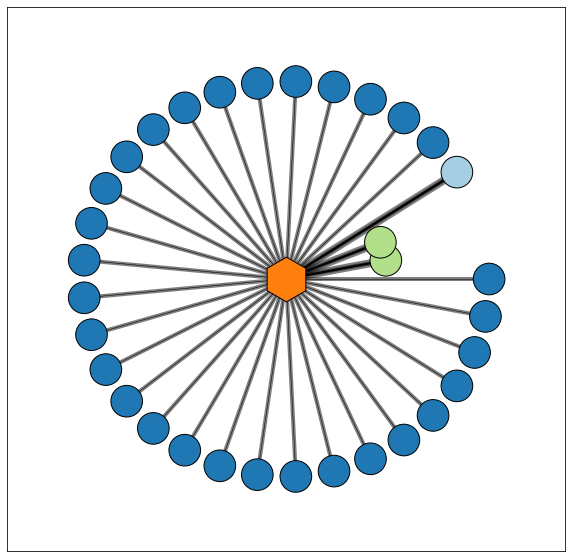

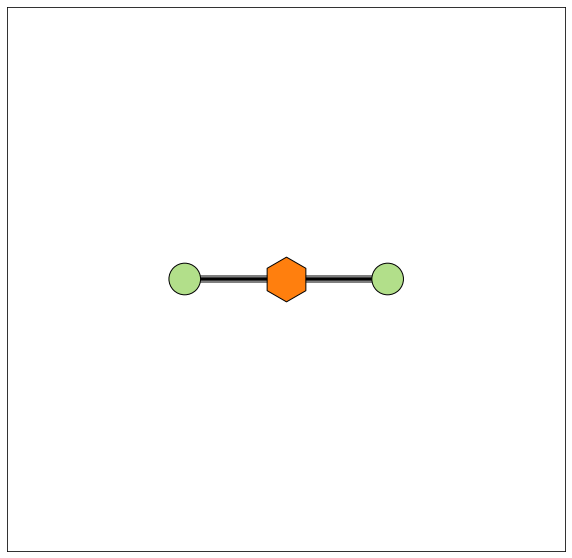

In [9]:
import networkx as nx
def choose_colour(age):
    if age <= 18:
        return '#1f78b4'
    elif age <= 39:
        return '#a6cee3'
    elif age <= 64:
        return '#b2df8a'
    else:
        return '#33a02c'
################################################## child p2  #######################################

f,ax = plt.subplots(figsize=(10,10))

### dont run again just load data 
with open(f'output_data/figs/ego_data_c2.json','r') as f:
    contacts = json.load(f)

# make graph
n = len(contacts.keys())
G = nx.Graph()
G.add_node(n)
for i in range(n):
    G.add_edge(0,i+1)

# position it for figure
center_node = 0 
edge_nodes = set(G) - {center_node}
pos = nx.circular_layout(G.subgraph(edge_nodes))
pos [center_node] = np.array([0,0])

#frequency [age, gender, frequency, phys, duration]
node_size = 200
node_sizes, node_colours, phys = [], [], []
for i in G.subgraph(edge_nodes).nodes:
    # age
    if pd.notna(contacts[f'{i-1}'][0]):
        node_colours.append(choose_colour(contacts[f'{i-1}'][0]))
    else:
        node_colours.append('#000000')
    # frequency
    if pd.notna(contacts[f'{i-1}'][2]):
        node_sizes.append(node_size*5)
    else:
        node_sizes.append(node_size*5)
    # phys
    if pd.notna(contacts[f'{i-1}'][3]) and contacts[f'{i-1}'][3] == 1:
        phys.append(i)
    # duration
    if pd.notna(contacts[f'{i-1}'][-1]):
        if contacts[f'{i-1}'][-1] == 4:
            pos[i] *= 2/5
        else:
            pos[i] *= 4/5
    else:
        pos[i] *= 4/5
    
    
# node_size = 300
# node_sizes, node_colours = [4*node_size if i < 2 else 1*node_size for i in range(n)], ["tab:green" if i < 2 else "gold" for i in range(n)]
# node_size, node_colour = [node_sizes[i-1] for i in G.subgraph(edge_nodes).nodes], [node_colours[i-1] for i in G.subgraph(edge_nodes).nodes] 


options = {"node_size": node_sizes, "node_color": node_colours, "node_shape": 'o', 'alpha':1}
nx.draw_networkx_nodes(G.subgraph(edge_nodes), pos=pos, ax=ax, **options)
options = {"node_size": 10*node_size, "node_color": "tab:orange", "node_shape": 'h'}
nx.draw_networkx_nodes(G.subgraph({center_node}), ax=ax, pos=pos, **options)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=0.5)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=4, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=[(0, a) for a in phys], width=2)
nx.draw_networkx_edges(G, pos, edgelist=[(0, a) for a in phys], width=8,alpha=0.5)

#maybe include this for ages?
# labels = {}; labels[0] = ''; labels[1] = '1'; labels[2] = '2'; labels[3] = '2'; labels[4] = '4'; labels[5] ='1'
# nx.draw_networkx_labels(G, pos, labels, font_size=30, font_color="whitesmoke", ax=ax)

ax.collections[0].set_edgecolor("#000000")
ax.collections[1].set_edgecolor("#000000")
ax.collections[2].set_edgecolor("#000000")
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])
ax.set_xlim([1.1*x for x in ax.get_xlim()])
ax.set_ylim([1.1*y for y in ax.get_ylim()])

# plt.savefig("figs/child_p2")
plt.show()

################################################################# child p1 #########################################################

f,ax = plt.subplots(figsize=(10,10))

contacts = {'0': [50,'F',1,1,1,4], '1': [50,'M', 1,1,1,4]}
# make graph
n = len(contacts.keys())
G = nx.Graph()
G.add_node(n)
for i in range(n):
    G.add_edge(0,i+1)

# position it for figure
center_node = 0 
edge_nodes = set(G) - {center_node}
pos = nx.circular_layout(G.subgraph(edge_nodes))
pos [center_node] = np.array([0,0])

#frequency [age, gender, frequency, phys, duration]
node_size = 200
node_sizes, node_colours, phys = [], [], []
for i in G.subgraph(edge_nodes).nodes:
    # age
    if pd.notna(contacts[f'{i-1}'][0]):
        node_colours.append(choose_colour(contacts[f'{i-1}'][0]))
    else:
        node_colours.append('#000000')
    # frequency
    if pd.notna(contacts[f'{i-1}'][2]):
        node_sizes.append(node_size*5)
    else:
        node_sizes.append(node_size*5)
    # phys
    if pd.notna(contacts[f'{i-1}'][3]) and contacts[f'{i-1}'][3] == 1:
        phys.append(i)
    # duration
    if pd.notna(contacts[f'{i-1}'][-1]):
        if contacts[f'{i-1}'][-1] == 4:
            pos[i] *= 2/5
        else:
            pos[i] *= 4/5
    else:
        pos[i] *= 4/5
    

# node_size = 300
# node_sizes, node_colours = [4*node_size if i < 2 else 1*node_size for i in range(n)], ["tab:green" if i < 2 else "gold" for i in range(n)]
# node_size, node_colour = [node_sizes[i-1] for i in G.subgraph(edge_nodes).nodes], [node_colours[i-1] for i in G.subgraph(edge_nodes).nodes] 


options = {"node_size": node_sizes, "node_color": node_colours, "node_shape": 'o', 'alpha':1}
nx.draw_networkx_nodes(G.subgraph(edge_nodes), pos=pos, ax=ax, **options)
options = {"node_size": 10*node_size, "node_color": "tab:orange", "node_shape": 'h'}
nx.draw_networkx_nodes(G.subgraph({center_node}), ax=ax, pos=pos, **options)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=0.5)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=4, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=[(0, a) for a in phys], width=2)
nx.draw_networkx_edges(G, pos, edgelist=[(0, a) for a in phys], width=8,alpha=0.5)

#maybe include this for ages?
# labels = {}; labels[0] = ''; labels[1] = '1'; labels[2] = '2'; labels[3] = '2'; labels[4] = '4'; labels[5] ='1'
# nx.draw_networkx_labels(G, pos, labels, font_size=30, font_color="whitesmoke", ax=ax)

ax.collections[0].set_edgecolor("#000000")
ax.collections[1].set_edgecolor("#000000")
ax.collections[2].set_edgecolor("#000000")
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])
ax.set_xlim([1.1*x for x in ax.get_xlim()])
ax.set_ylim([1.1*y for y in ax.get_ylim()])

# plt.savefig("figs/child_p2")
plt.show()


{'0': [23, 'F', 2.0, 2, 5.0], '1': [20, 'F', 1.0, 1, 5.0], '2': [41, 'F', 3.0, 2, 5.0], '3': [43, 'F', 3.0, 2, 5.0], '4': [39, 'F', 3.0, 2, 5.0], '5': [48, 'F', 2.0, 2, 5.0], '6': [53, 'F', 2.0, 2, 5.0], '7': [29, 'F', 2.0, 2, 5.0], '8': [50, 'F', 2.0, 2, 5.0], '9': [31, 'F', 2.0, 2, 5.0], '10': [40, 'F', 5.0, 2, 5.0], '11': [63, 'M', 5.0, 2, 5.0], '12': [61, 'M', 5.0, 2, 5.0], '13': [68, 'M', 5.0, 2, 3.0], '14': [63, 'F', 5.0, 2, 5.0], '15': [22, 'M', 3.0, 2, 5.0], '16': [28, 'M', 2.0, 2, 5.0]}


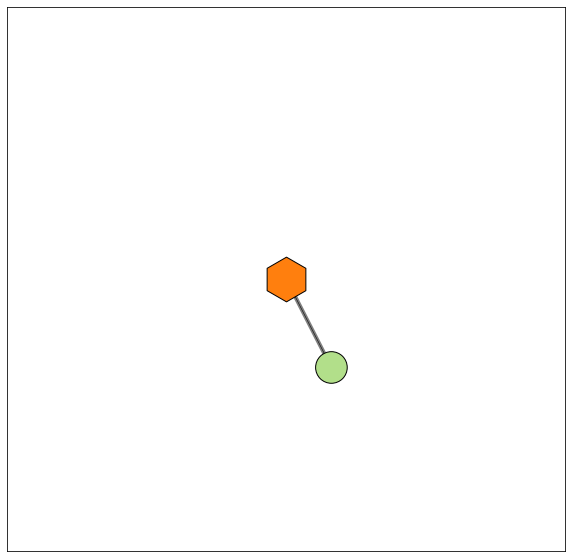

In [11]:
# find the nurses in the data
ids = df_extra[df_extra['part_occupation'] == 'Nursing and midwifery professionals']['part_id']
ids = [a for a in ids]
num_contacts = [len(df_cont[df_cont['part_id']==a]) for a in ids]

n_cont = 17
# print(ids)
target = [a for i,a in enumerate(ids) if num_contacts[i] == n_cont]
for part_id in [target[-1]]:
    # try:
    contacts = {}
    df_target = df_cont[df_cont['part_id'] == part_id]
    for i in range(n_cont):
        # save details of contact [age, gender, frequency, phys, duration]
        contacts[f'{i}'] = [np.random.randint(int(list(df_target['cnt_age_est_min'])[i]), int(list(df_target['cnt_age_est_max'])[i])), list(df_target['cnt_gender'])[i], list(df_target['frequency_multi'])[i], list(df_target['phys_contact'])[i], list(df_target['duration_multi'])[i]]
    with open(f'output_data/figs/ego_data_nurse.json', 'w') as f:
        json.dump(contacts,f)
    print(contacts)
    # except:
    #     print('oops')

def choose_colour(age):
    if age <= 18:
        return '#1f78b4'
    elif age <= 39:
        return '#a6cee3'
    elif age <= 64:
        return '#b2df8a'
    else:
        return '#33a02c'
################################################## nurse #######################################

f,ax = plt.subplots(figsize=(10,10))

with open(f'output_data/figs/ego_data_nurse.json','r') as f:
    contacts = json.load(f)

# make graph
n = len(contacts.keys())
G = nx.Graph()
G.add_node(n)
for i in range(n):
    G.add_edge(0,i+1)

# position it for figure
center_node = 0 
edge_nodes = set(G) - {center_node}
pos = nx.circular_layout(G.subgraph(edge_nodes))
pos [center_node] = np.array([0,0])

#frequency [age, gender, frequency, phys, duration]
node_size = 200
node_sizes, node_colours = [], []
for i in G.subgraph(edge_nodes).nodes:
    # age
    if pd.notna(contacts[f'{i-1}'][0]):
        node_colours.append(choose_colour(contacts[f'{i-1}'][0]))
    else:
        node_colours.append('#000000')
    # frequency
    if pd.notna(contacts[f'{i-1}'][2]):
        node_sizes.append(node_size*contacts[f'{i-1}'][2])
    else:
        node_sizes.append(node_size)
    # duration
    if pd.notna(contacts[f'{i-1}'][-1]):
        pos[i] *= 1 - contacts[f'{i-1}'][-1]/5
    else:
        pos[i] *= 1
    

# node_size = 300
# node_sizes, node_colours = [4*node_size if i < 2 else 1*node_size for i in range(n)], ["tab:green" if i < 2 else "gold" for i in range(n)]
node_size_order, node_colour_order = [node_sizes[i-1] for i in G.subgraph(edge_nodes).nodes], [node_colours[i-1] for i in G.subgraph(edge_nodes).nodes] 


options = {"node_size": node_size_order, "node_color": node_colour_order, "node_shape": 'o', 'alpha':1}
nx.draw_networkx_nodes(G.subgraph(edge_nodes), pos=pos, ax=ax, **options)
options = {"node_size": 10*node_size, "node_color": "tab:orange", "node_shape": 'h'}
nx.draw_networkx_nodes(G.subgraph({center_node}), ax=ax, pos=pos, **options)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=0.5)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=4, alpha=0.5)

#maybe include this for ages?
# labels = {}; labels[0] = ''; labels[1] = '1'; labels[2] = '2'; labels[3] = '2'; labels[4] = '4'; labels[5] ='1'
# nx.draw_networkx_labels(G, pos, labels, font_size=30, font_color="whitesmoke", ax=ax)

ax.collections[0].set_edgecolor("#000000")
ax.collections[1].set_edgecolor("#000000")
ax.collections[2].set_edgecolor("#000000")
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])
ax.set_xlim([1.1*x for x in ax.get_xlim()])
ax.set_ylim([1.1*y for y in ax.get_ylim()])

# plt.savefig("ego_networks/child_p2")
plt.show()

In [ ]:
# find the mathematician
ids = df_extra[df_extra['part_occupation'] == 'Mathematicians, statisticians and related professionals']['part_id']
ids = [a for a in ids]
n_cont = 1
num_contacts = [len(df_cont[df_cont['part_id']==a]) for a in ids]
target = [a for i,a in enumerate(ids) if num_contacts[i] == 1]
dists = []
for part_id in target:
    df_target = df_cont[df_cont['part_id'] == part_id]
    dists.append([np.random.randint(int(list(df_target['cnt_age_est_min'])[i]), int(list(df_target['cnt_age_est_max'])[i])) for i in range(n_cont)])
print(dists)

def choose_colour(age):
    if age <= 18:
        return '#1f78b4'
    elif age <= 39:
        return '#a6cee3'
    elif age <= 64:
        return '#b2df8a'
    else:
        return '#33a02c'
################################################## mathematician #######################################

f,ax = plt.subplots(figsize=(10,10))

# make graph
n = len(contacts.keys())
G = nx.Graph()
G.add_node(n)
for i in range(n):
    G.add_edge(0,i+1)

# position it for figure
center_node = 0 
edge_nodes = set(G) - {center_node}
pos = nx.circular_layout(G.subgraph(edge_nodes))
pos [center_node] = np.array([0,0])

#frequency [age, gender, frequency, phys, duration]
node_size = 300
node_sizes, node_colours = [], []
for i in G.subgraph(edge_nodes).nodes:
    # age
    if pd.notna(contacts[f'{i-1}'][0]):
        node_colours.append(choose_colour(contacts[f'{i-1}'][0]))
    else:
        node_colours.append('#000000')
    # frequency
    if pd.notna(contacts[f'{i-1}'][2]):
        node_sizes.append(node_size*contacts[f'{i-1}'][2])
    else:
        node_sizes.append(node_size)
    # duration
    if pd.notna(contacts[f'{i-1}'][-1]):
        pos[i] *= 1 - contacts[f'{i-1}'][-1]/5
    else:
        pos[i] *= 1
    

# node_size = 300
# node_sizes, node_colours = [4*node_size if i < 2 else 1*node_size for i in range(n)], ["tab:green" if i < 2 else "gold" for i in range(n)]
node_size_order, node_colour_order = [node_sizes[i-1] for i in G.subgraph(edge_nodes).nodes], [node_colours[i-1] for i in G.subgraph(edge_nodes).nodes] 


options = {"node_size": node_size_order, "node_color": node_colour_order, "node_shape": 'o', 'alpha':1}
nx.draw_networkx_nodes(G.subgraph(edge_nodes), pos=pos, ax=ax, **options)
options = {"node_size": 6*node_size, "node_color": "tab:orange", "node_shape": 'h'}
nx.draw_networkx_nodes(G.subgraph({center_node}), ax=ax, pos=pos, **options)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=0.5)
nx.draw_networkx_edges(G, pos=pos, ax=ax, width=4, alpha=0.5)

#maybe include this for ages?
# labels = {}; labels[0] = ''; labels[1] = '1'; labels[2] = '2'; labels[3] = '2'; labels[4] = '4'; labels[5] ='1'
# nx.draw_networkx_labels(G, pos, labels, font_size=30, font_color="whitesmoke", ax=ax)

ax.collections[0].set_edgecolor("#000000")
ax.collections[1].set_edgecolor("#000000")
ax.collections[2].set_edgecolor("#000000")
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])
ax.set_xlim([1.1*x for x in ax.get_xlim()])
ax.set_ylim([1.1*y for y in ax.get_ylim()])

# plt.savefig("ego_networks/child_p2")
plt.show()

In [ ]:
# find the general manager
ids = df_extra[df_extra['part_occupation'] == 'Mathematicians, statisticians and related professionals']['part_id']
ids = [a for a in ids]
n_cont = 1
num_contacts = [len(df_cont[df_cont['part_id']==a]) for a in ids]
target = [a for i,a in enumerate(ids) if num_contacts[i] == 1]
dists = []
for part_id in target:
    df_target = df_cont[df_cont['part_id'] == part_id]
    dists.append([np.random.randint(int(list(df_target['cnt_age_est_min'])[i]), int(list(df_target['cnt_age_est_max'])[i])) for i in range(n_cont)])
print(dists)

[[21, 21, 40, 37, 41, 50, 47, 33, 48, 26, 39, 56, 62, 68, 58, 23, 28]]
[[30], [29], [27], [30], [33], [32], [25], [57], [21], [58], [61], [57], [63], [63], [59], [43]]
[[29], [33], [28], [27], [29], [32], [33], [63], [21], [56], [62], [55], [56], [62], [56], [43]]


### surfaces

22121 2310
(-15.380248366793262, -1.0772012385736316)
22121 19811
(-11.598619036890986, -1.6901655477991748)


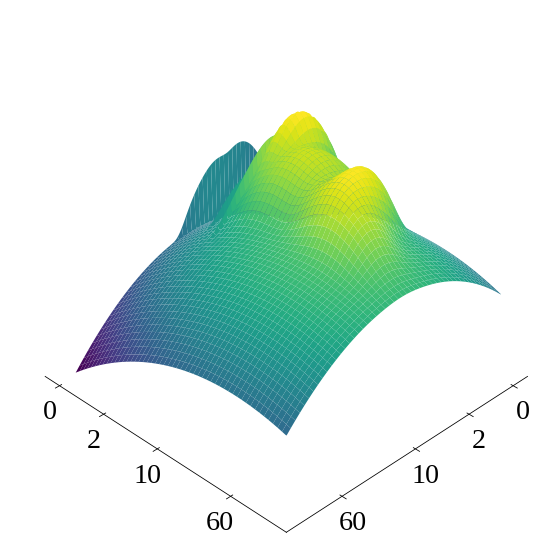

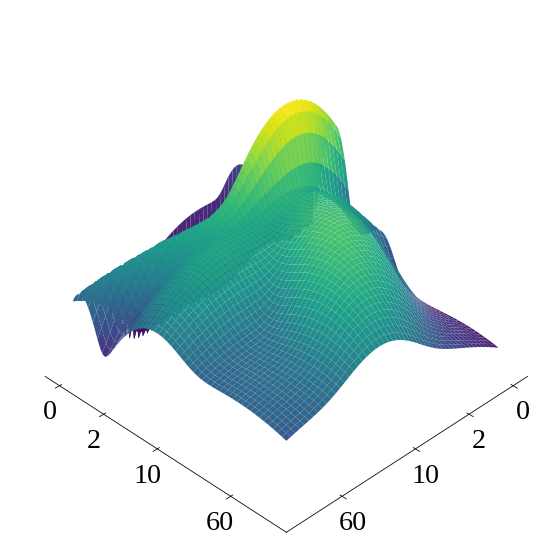

In [8]:
# defining surface and axes
# partition the data of under 18 and over 18
import scipy.ndimage
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 30})

n=2000
max_x = 5
datas = ['comix2']
for i, data in enumerate(datas):
    with open(f'input_data/gmm/optimal_components_{data}_log.json', 'r') as f:
        optimal_num_components = json.load(f)
    ##################### read fits ####################################
    with open(f'input_data/egos/{data}.json', 'r') as f:
        egos_pre = json.load(f)
    # reduce egos to 2 dimensions 
    egos = [{'age': 0 if ego['age'] < 2 else 1, 'contacts': [sum(ego['contacts'][:3]), sum(ego['contacts'][3:])], 'degree': ego['degree']} for ego in egos_pre]
    classifier = []
    samples = []
    for l in [0,1]:
        classifier.append(sklearn.mixture.GaussianMixture(n_components=10, covariance_type='full'))
        egos_age = [a for a in egos if a['age'] == l]
        print(len(egos_pre), len(egos_age))
        ## use log(k+1) instead of k to fit
        X = [[math.log(b+1) for b in a['contacts']] for a in egos_age]
        classifier[l].fit(X)
    
        x=np.outer(np.linspace(0,max_x,n), np.ones(n)) 
        y=x.copy().T
        z=np.zeros((len(x), len(x[0])))
        for i in range(len(z)):
            tmp = classifier[l].score_samples([[x[i,j], y[i,j]] for j in range(len(x[i]))])
            # print(tmp)
            for j, val in enumerate(tmp):
                z[i,j] = val
        # for i in range(len(x)):
        #     for j in range(len(x[0])):
        #         z[i,j] = classifier[l].predict_proba(np.array(x[i][j],y[i][j]))
    
        # x = np.outer(np.linspace(-2, 2, 10), np.ones(10))
        # y = x.copy().T
        # z = np.cos(x ** 2 + y ** 3)
        # print(z)

        fig = plt.figure(figsize=(12,10))

        # syntax for 3-D plotting
        # ax = plt.axes(projection='3d')
        ax = fig.add_subplot(projection='3d')

        #smoothing
        # z = scipy.signal.savgol_filter(z, window_length=15, polyorder=3, axis=0)
        # z = scipy.ndimage.median_filter(z, size=5)
        z = scipy.ndimage.gaussian_filter(z, sigma=5)

        
        # syntax for plotting
        ax.plot_surface(y,x, z, cmap='viridis',
                        edgecolor='none')

        # Update the axis view and title
        elev=35; azim=225; roll=0
        ax.view_init(elev=elev, azim=azim, roll=roll)
        # ax.set_title(f'{data}: {l}')
        ax.grid(False)
        ax.invert_xaxis()
        ax.invert_yaxis()
        # ax.set_ylabel('# Contacts 0-17', labelpad=15)
        # ax.set_xlabel('# Contacts 18+', labelpad=15)
        ax.set_zticks([])
        xticks=[0,2,10,60]
        ax.set_xticks([np.log(a+1) for a in xticks], xticks)
        ax.set_yticks([np.log(a+1) for a in xticks], xticks)
        print(ax.get_zlim())
        
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        ax.xaxis.pane.set_edgecolor('none')
        ax.yaxis.pane.set_edgecolor('none')
        ax.zaxis.pane.set_edgecolor('none')
        
        if l == 0:
            plt.rc('xtick', labelsize=32)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=32)
        plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=28)
        ax.zaxis.line.set_lw(0.)
        # ax.set_xlim([0,max_x])
        # ax.set_ylim([0,max_x])
        # ax.set_zlim([-15,1])
        plt.savefig(f'output_data/gmm/surface_{data}_{l}.png',transparent=True)

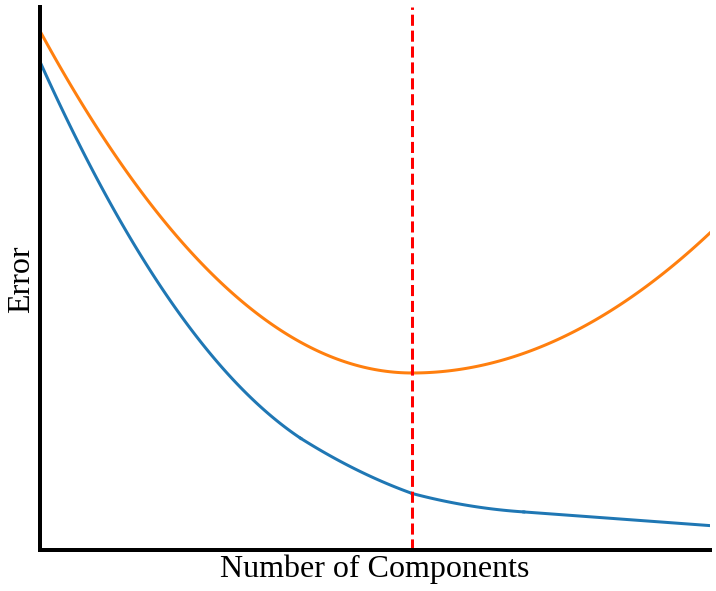

In [ ]:
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(12,10))

x1 = np.linspace(-1,0,100)
x2 = np.linspace(0,.8,100)
plt.plot(x1,np.power((x1),2), 'tab:orange',linewidth=3)
plt.plot(x2,np.power((x2*.8),2), 'tab:orange',linewidth=3)

x1 = np.linspace(-1,-0.3,100)
x2 = np.linspace(-0.3,0,100)
x3 = np.linspace(0,0.3,100)
x4 = np.linspace(0.3,0.8,100)
plt.plot(x1,np.power((x1)*1.1,2)-.3, 'tab:blue', linewidth=3)
plt.plot(x2,np.power((x2-.4)*.7,2)-.4312, 'tab:blue', linewidth=3)
plt.plot(x3,np.power((x3-.4)*.6,2)-.4104, 'tab:blue', linewidth=3)
plt.plot(x4,-.4068-.08*(x4-.3), 'tab:blue', linewidth=3)

# plt.text(-.315,0.6,'Optimal   Complexity',color='tab:red',fontsize=32)
# plt.text(.6,.34,'Test',color='tab:orange',fontsize=38,rotation=40)
# plt.text(.58,-.4,'Train',color='tab:blue', fontsize=38)

# plt.text(-.42,.9,'Underfit',color='k', fontsize=38)
# plt.text(.12,.9,'Overfit',color='k', fontsize=38)

# plt.arrow(-.45, .935, -.1, 0, length_includes_head=False,
#           head_width=0.06, head_length=0.05, color='black')
# plt.arrow(.41, .935, .1, 0, length_includes_head=False,
#           head_width=0.06, head_length=0.05, color='k')

cur_lims = [plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]]

plt.vlines([0], cur_lims[0], cur_lims[1], 'r',linestyles='--',linewidth=3)

plt.xticks([])
plt.yticks([])

# plt.xlabel('Number of Components')
# plt.ylabel('Error')

for axis in ['bottom','left']:
    plt.gca().spines[axis].set_linewidth(4)

for axis in ['top','right']:
    plt.gca().spines[axis].set_linewidth(0)

plt.xlim([-1,.8])
plt.ylim(cur_lims)
plt.savefig('output_data/gmm/num_comp.png',transparent=False)

22121 2310
22121 19811


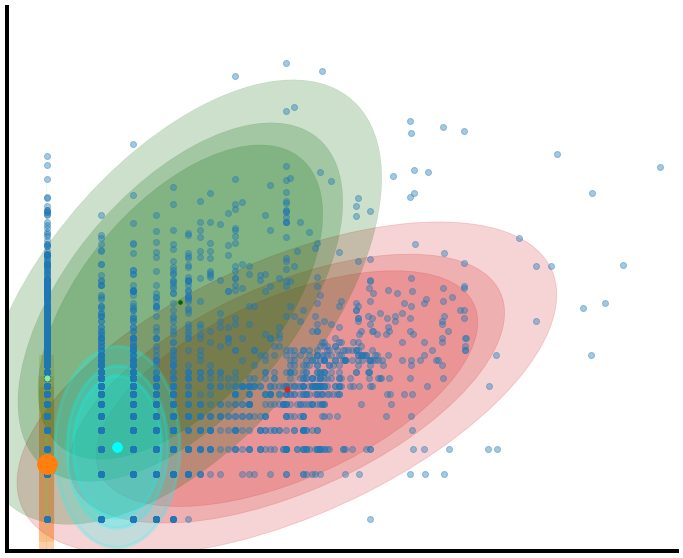

In [42]:
from scipy.stats import chi2
import matplotlib
# partition the data of under 18 and over 18
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams.update({'font.size': 20})

n_comp = 5
datas = ['comix2']
for i, data in enumerate(datas):
    with open(f'input_data/gmm/optimal_components_{data}_log.json', 'r') as f:
        optimal_num_components = json.load(f)
    ##################### read fits ####################################
    with open(f'input_data/egos/{data}.json', 'r') as f:
        egos_pre = json.load(f)
    # reduce egos to 2 dimensions 
    egos = [{'age': 0 if ego['age'] < 2 else 1, 'contacts': [sum(ego['contacts'][:3]), sum(ego['contacts'][3:])], 'degree': ego['degree']} for ego in egos_pre]
    classifier = []
    samples = []
    for l in [0,1]:
        classifier.append(sklearn.mixture.GaussianMixture(n_components=n_comp, covariance_type='full'))
        egos_age = [a for a in egos if a['age'] == l]
        print(len(egos_pre), len(egos_age))
        ## use log(k+1) instead of k to fit
        X = [[math.log(b+1) for b in a['contacts']] for a in egos_age]
        classifier[l].fit(X)
        
    #     centers, cov, weights = [], [], []
    #     for center in classifier[-1].means_:
    #         centers.append(center)
    #     for covariance in classifier[-1].covariances_:
    #         cov.append(covariance)
    #     for weight in classifier[-1].weights_:
    #         weights.append(weight)
            
        # print(centers)
        # print(cov)
        # print(weights)
        
        # centers, cov, weights = np.array(centers), np.array(cov), np.array(weights)
        # fig, ax = plt.subplots(1,1,figsize=(12,10))

        # ####################### each elipse plotted #######################
        # # Calculate scaling factor for 95% confidence interval
        # confidence_level = 0.95
        # scale = np.sqrt(chi2.ppf(confidence_level, df=2))

        # # Plot confidence ellipses
        # for i, (center, cov, weight) in enumerate(zip(centers, cov, weights)):
        #     # Calculate eigenvalues and eigenvectors
        #     eigvals, eigvecs = np.linalg.eigh(cov)
        #     order = eigvals.argsort()[::-1]
        #     eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            
        #     # Calculate ellipse orientation
        #     angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            
        #     # Calculate ellipse dimensions
        #     width, height = 2 * scale * np.sqrt(eigvals)
            
        #     # Create ellipse with weight-proportional linewidth
        #     lw = 20*weight
        #     ellipse = matplotlib.patches.Ellipse(center, width, height, angle=angle,
        #                         edgecolor='blue', facecolor='none',
        #                         linewidth=lw, linestyle='-')
        #     ax.add_patch(ellipse)
            
        #     # Plot component centers
        #     ax.scatter(center[0], center[1], s=500*weight, c='red', zorder=2)
        
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    
    # saved values so we do not have to rerun the process every time
    centers = [[0.       , 0.8497018], [3.05072964, 2.03610064], [0.        , 2.20829167], [1.69797138, 3.38907142], [0.89931593, 1.12356798]]
    cov = [[[1.00000000e-06, 0.00000000e+00],[0.00000000e+00, 3.15110863e-01]], 
        [[1.27380924, 0.54578293],[0.54578293, 0.73737824]], 
        [[1.00000000e-06, 0.00000000e+00],[0.00000000e+00, 1.00378173e+00]], 
        [[0.70906735, 0.53888079],[0.53888079, 1.31077431]], 
        [[0.06852359, 0.00139266],[0.00139266, 0.2684105 ]]]
    weights = [0.7329802032821193, 0.039986349461309925, 0.04062543879673585, 0.01732260847931158, 0.16908539998037048]
    colours = ['tab:orange', 'tab:red', 'lightgreen', 'darkgreen', 'cyan']
    for i, (center, cov, weight) in enumerate(zip(centers, cov, weights)):
        for confidence_level in [0.9,0.95,0.99]:
            scale = np.sqrt(chi2.ppf(confidence_level, df=2))
            eigvals, eigvecs = np.linalg.eigh(cov)
            order = eigvals.argsort()[::-1]
            eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            
            # Calculate ellipse orientation
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            
            # Calculate ellipse dimensions
            width, height = 2 * scale * np.sqrt(eigvals)
            
            # Create ellipse with weight-proportional linewidth
            lw = 20*weight
            ellipse = matplotlib.patches.Ellipse(center, width, height, angle=angle,
                                edgecolor=colours[i], facecolor=colours[i],
                                linewidth=lw, linestyle='-',alpha=0.2)
            ax.add_patch(ellipse)
            
            # Plot component centers
            ax.scatter(center[0], center[1], s=500*weight, c=colours[i], zorder=2)
    
    
    ax.scatter([a[0] for a in X], [a[1] for a in X],color='tab:blue',alpha=0.4, zorder=1)
    ax.set_xlim([-.5,8])
    ax.set_ylim([-.5,8])
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(4)

    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)
    # plt.scatter([a[0] for a in centers], [a[1] for a in centers], color='red')
    plt.savefig('output_data/gmm/fitting.png')
    plt.show()
    

/tmp/ipykernel_7489/3482100294.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples2 = np.random.multivariate_normal([4,4], 0.9*np.array([[1.1,1.5],[1.5,1.1]]), size=500)
/tmp/ipykernel_7489/3482100294.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples3 = np.random.multivariate_normal([5,2], .35*np.array([[0.7,1],[1,0.7]]), size=500)


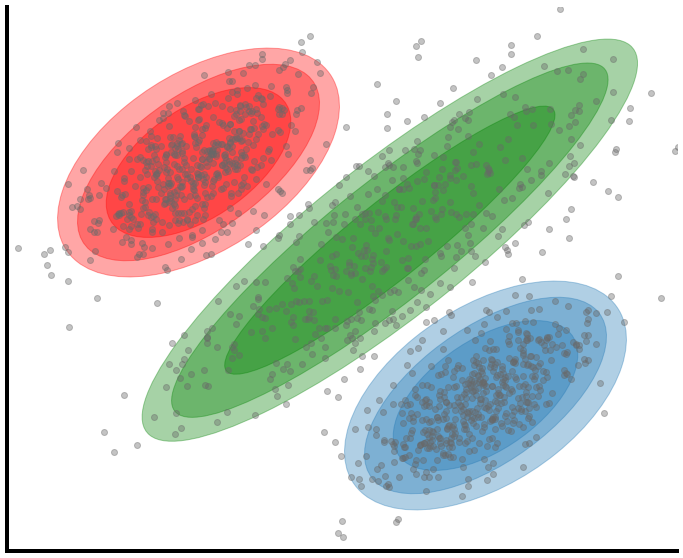

In [43]:
### maybe try a fake example to make it more obvious
from scipy.stats import chi2
import matplotlib

samples1 = np.random.multivariate_normal([2,5], .35*np.array([[1,0.7],[0.7,1]]), size=500)
samples2 = np.random.multivariate_normal([4,4], 0.9*np.array([[1.1,1.5],[1.5,1.1]]), size=500)
samples3 = np.random.multivariate_normal([5,2], .35*np.array([[0.7,1],[1,0.7]]), size=500)
fig,ax = plt.subplots(figsize=(12,10))
ellipse = matplotlib.patches.Ellipse([2,5], 2.4, 1.3, angle=45,
                    edgecolor='red', facecolor='red',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([2,5], 3.2, 1.6, angle=45,
                    edgecolor='red', facecolor='red',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([2,5], 3.6, 2.1, angle=45,
                    edgecolor='red', facecolor='red',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([4,4], 4.8, .9, angle=45,
                    edgecolor='green', facecolor='green',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([4,4], 6.3, 1.4, angle=45,
                    edgecolor='green', facecolor='green',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([4,4], 7.1, 1.8, angle=45,
                    edgecolor='green', facecolor='green',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([5,2], 2.4, 1.3, angle=45,
                    edgecolor='tab:blue', facecolor='tab:blue',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([5,2], 3.2, 1.6, angle=45,
                    edgecolor='tab:blue', facecolor='tab:blue',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ellipse = matplotlib.patches.Ellipse([5,2], 3.6, 2.1, angle=45,
                    edgecolor='tab:blue', facecolor='tab:blue',
                    linewidth=1, linestyle='-',alpha=0.35)
ax.add_patch(ellipse)
ax.scatter([a[0] for a in samples1], [a[1] for a in samples1], alpha=0.4,color='dimgrey')
ax.scatter([a[0] for a in samples2], [a[1] for a in samples2], alpha=0.4,color='dimgrey')
ax.scatter([a[0] for a in samples3], [a[1] for a in samples3], alpha=0.4,color='dimgrey')

ax.set_xlim([0,7])
ax.set_ylim([0,7])
ax.set_xticks([])
ax.set_yticks([])
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
# plt.scatter([a[0] for a in centers], [a[1] for a in centers], color='red')
plt.savefig('output_data/gmm/fitting_example.png',transparent=True)
plt.show()

/tmp/ipykernel_17570/1003245272.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  pts = np.random.multivariate_normal(mean=g["mean"], cov=g["cov"], size=n_samples)
/tmp/ipykernel_17570/1003245272.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(g["cmap"])
/tmp/ipykernel_17570/1003245272.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_color = cm.get_cmap(cmap_name)(0.5)
/tmp/ipykernel_17570/1003245272.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormap

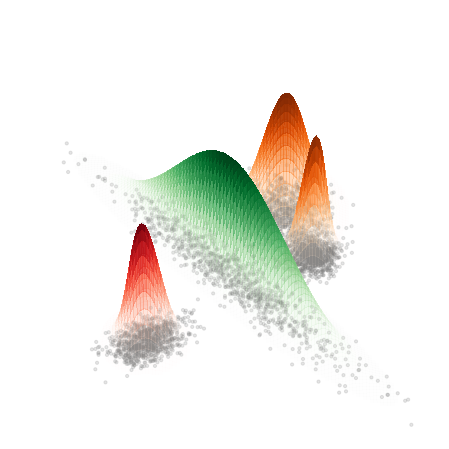

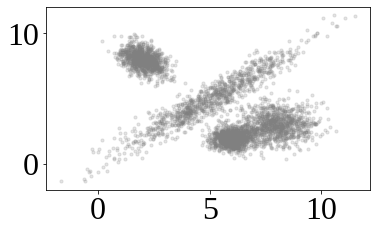

In [180]:
####################################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

# 1) Define three 2D Gaussians (means, covariances, and base colormaps)
# gaussians = [
#     {"mean": [0.0, 0.0], "cov": 1.5*np.array([[1.0, 0.0], [0.0, 1.0]]), "cmap": "Greens"},
#     {"mean": [3.0, 2.0], "cov": [[1.5, 0.5], [0.5, 1.0]], "cmap": "Oranges"},
#     {"mean": [-2.0, 3.0], "cov": np.array([[0.6, -0.9], [-0.3, 0.8]]), "cmap": "Blues"},
#     {"mean": [-1.0, -1.0], "cov": 2.5*np.array([[0.5, 0.3], [0.3, 0.8]]), "cmap": "Reds"},
# ]
gaussians = [
    {"mean": [5.0, 5.0], "cov": 2*np.array([[1.9,1.8], [1.8, 1.9]]), "cmap": "Greens"},
    {"mean": [2.0, 8.0], "cov": 0.3*np.array([[1,-1], [0, 1.0]]), "cmap": "Reds"},
    {"mean": [6, 2], "cov": 0.2*np.array([[1,0], [0, 1.0]]), "cmap": "Oranges"},
    {"mean": [8, 3], "cov": 0.7*np.array([[1,0], [0, 1.0]]), "cmap": "Oranges"},
]

# 2) Create a grid over which to evaluate each PDF
all_means = np.array([g["mean"] for g in gaussians])
xmin, ymin = all_means.min(axis=0) - 3
xmax, ymax = all_means.max(axis=0) + 3

n_grid = 400
x = np.linspace(xmin, xmax, n_grid)
y = np.linspace(ymin, ymax, n_grid)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))  # shape (n_grid, n_grid, 2)

# 3) Evaluate each Gaussian’s PDF on the grid
Zs = []
for g in gaussians:
    rv = multivariate_normal(mean=g["mean"], cov=g["cov"])
    Zs.append(rv.pdf(pos))

# 4) Sample points from each Gaussian (to plot at z=0)
n_samples = 1000
samples = []
for g in gaussians:
    pts = np.random.multivariate_normal(mean=g["mean"], cov=g["cov"], size=n_samples)
    samples.append((pts, g["cmap"]))

# 5) Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Choose a minimum z threshold (for clarity, don't plot below this level)
z_thresh = 0.001 * max(Z.max() for Z in Zs)  # e.g. 1% of the overall highest peak

for Z, g in zip(Zs, gaussians):
    Z = 0.1*Z/np.max(Z)
    # Mask out values below threshold
    Z_plot = np.where(Z < z_thresh, np.nan, Z)

    # Compute vmin and vmax ignoring NaNs
    vmin = np.nanmin(Z_plot)
    vmax = np.nanmax(Z_plot)

    # Normalize Z_plot for alpha mapping
    norm = Normalize(vmin=vmin, vmax=vmax)
    Z_norm = norm(Z_plot)  # will be NaN wherever Z_plot is NaN

    # Create an RGBA facecolors array based on the chosen colormap, 
    # and set alpha = Z_norm (so lower values are more transparent)
    cmap = cm.get_cmap(g["cmap"])
    facecolors = cmap(Z_norm)
    # wherever Z_plot is NaN, set alpha = 0
    facecolors[..., -1] = np.where(np.isnan(Z_plot), 0, Z_norm)

    # Plot the surface with per-face alpha
    ax.plot_surface(
        X, Y, Z_plot,
        rstride=4, cstride=4,
        facecolors=facecolors,
        linewidth=0,
        antialiased=False,
        shade=False
    )

# 6) Plot sampled points at z=0 (semi-transparent, matching each colormap)
for (pts, cmap_name) in samples:
    # Use a solid color from the middle of the colormap
    base_color = cm.get_cmap(cmap_name)(0.5)
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        np.zeros(n_samples),
        # color=base_color,
        color='grey',
        s=10,
        alpha=0.2
    )

fig1, ax1 = plt.subplots(1,1)  
for (pts, cmap_name) in samples:
    # Use a solid color from the middle of the colormap
    base_color = cm.get_cmap(cmap_name)(0.5)
    ax1.scatter(
        pts[:, 0],
        pts[:, 1],
        # color=base_color,
        color='grey',
        s=10,
        alpha=0.2
    )

# 7) Remove all axis labels, ticks, and title
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_title("")
ax.set_xlim([0,10])
ax.set_ylim([0,10])

ax.set_axis_off()
ax.xaxis.set_inverted(inverted=True)
ax.yaxis.set_inverted(inverted=True)
# 8) Optionally adjust viewing angle
ax.view_init(elev=50, azim=0)

plt.tight_layout()
plt.show()

############################################################################


# # 1) Define three 2D Gaussians (means, covariances, and base colormaps)
# gaussians = [
#     {"mean": [5.0, 5.0], "cov": 2*np.array([[1.9,1.8], [1.8, 1.9]]), "cmap": "Greens"},
#     {"mean": [2.0, 8.0], "cov": 0.3*np.array([[1,-1], [0, 1.0]]), "cmap": "Reds"},
#     {"mean": [6, 2], "cov": 0.2*np.array([[1,0], [0, 1.0]]), "cmap": "Oranges"},
#     {"mean": [8, 3], "cov": 0.7*np.array([[1,0], [0, 1.0]]), "cmap": "Oranges"},
# ]

# # 4) Sample points from each Gaussian (to plot at z=0)
# n_samples = 1000
# samples = []
# for g in gaussians:
#     pts = np.random.multivariate_normal(mean=g["mean"], cov=g["cov"], size=n_samples)
#     samples.append((pts, g["cmap"]))

# fig1, ax1 = plt.subplots(1,1)  
# for (pts, cmap_name) in samples:
#     # Use a solid color from the middle of the colormap
#     base_color = cm.get_cmap(cmap_name)(0.5)
#     ax1.scatter(
#         pts[:, 0],
#         pts[:, 1],
#         # color=base_color,
#         color='grey',
#         s=10,
#         alpha=0.2
#     )
# ax1.set_xlim([0,10])
# ax1.set_ylim([0,10])
# plt.show()

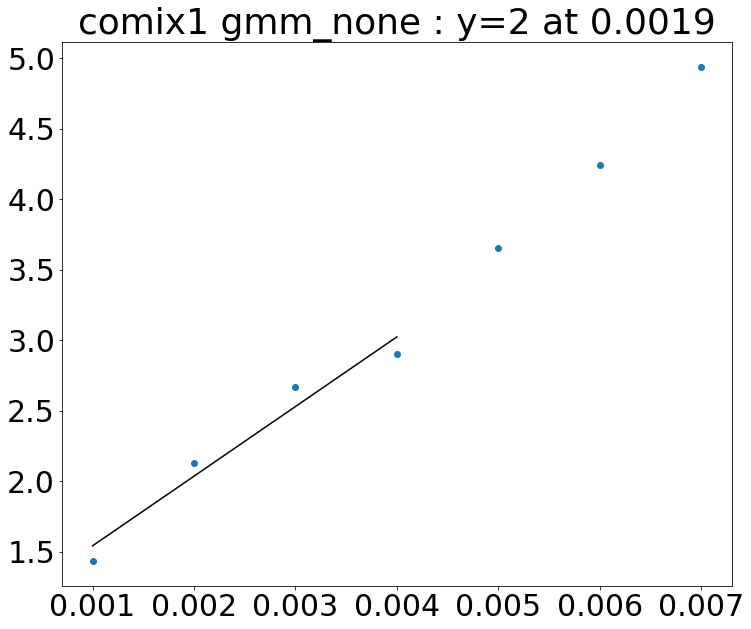

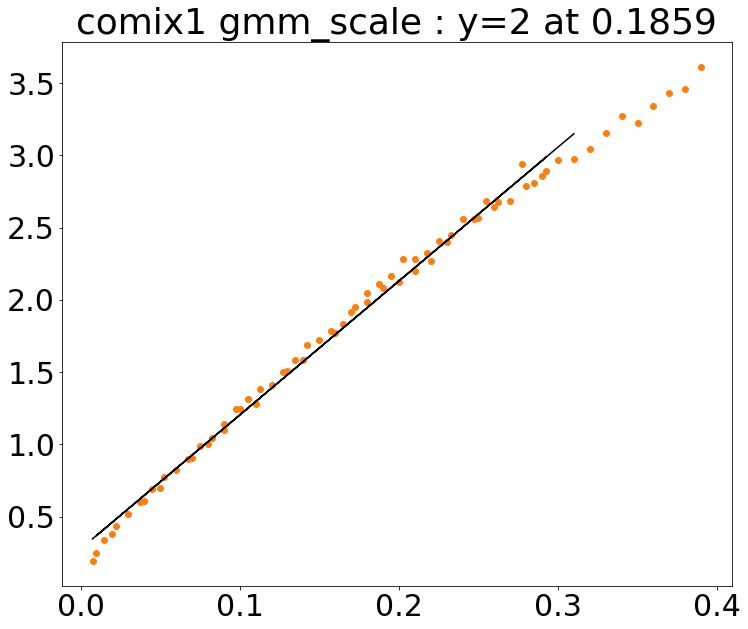

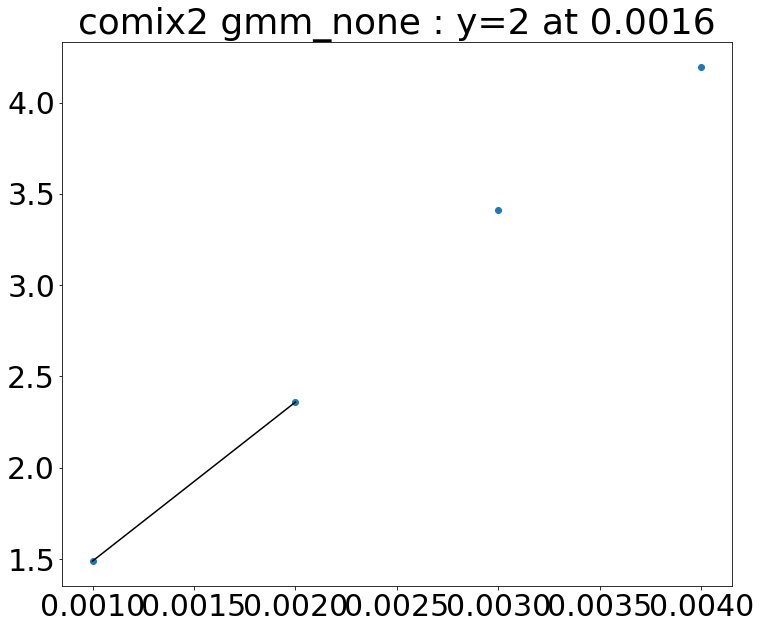

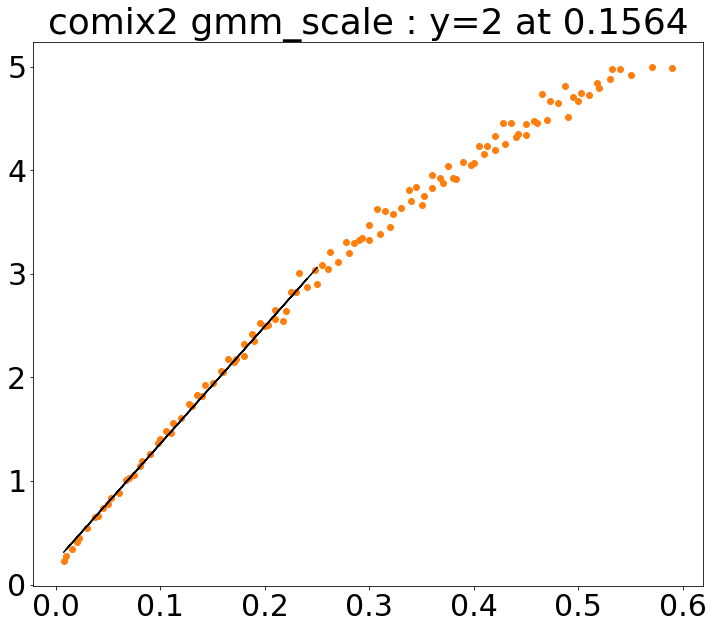

/tmp/ipykernel_9041/3080583198.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  plt.title(f'{data} {model} : y=2 at {np.round((2-m.intercept_)/m.coef_[0],4)}')


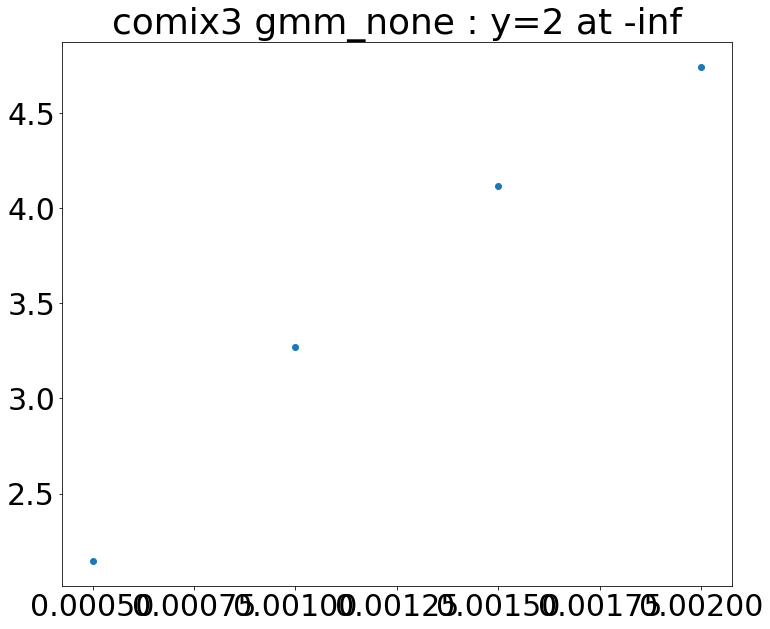

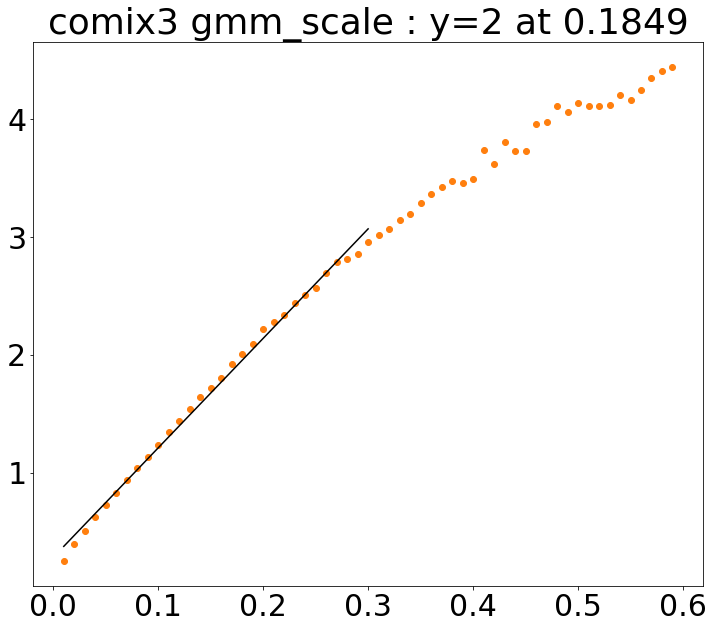

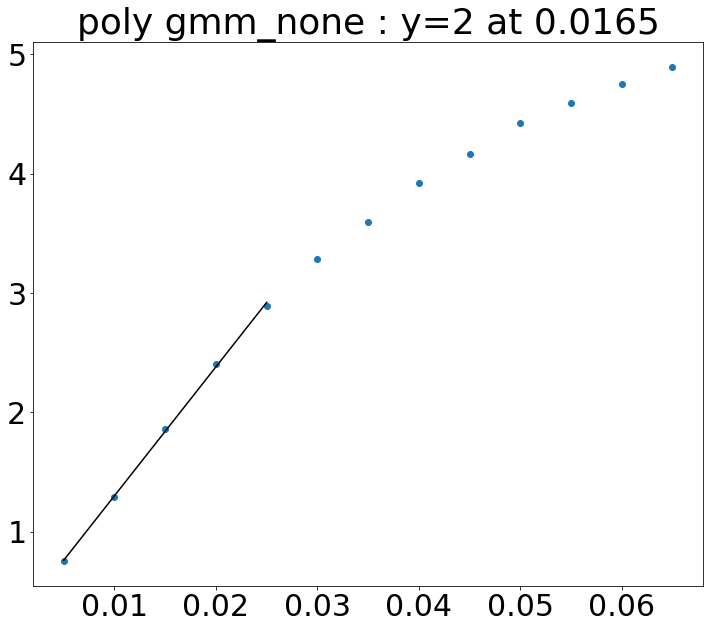

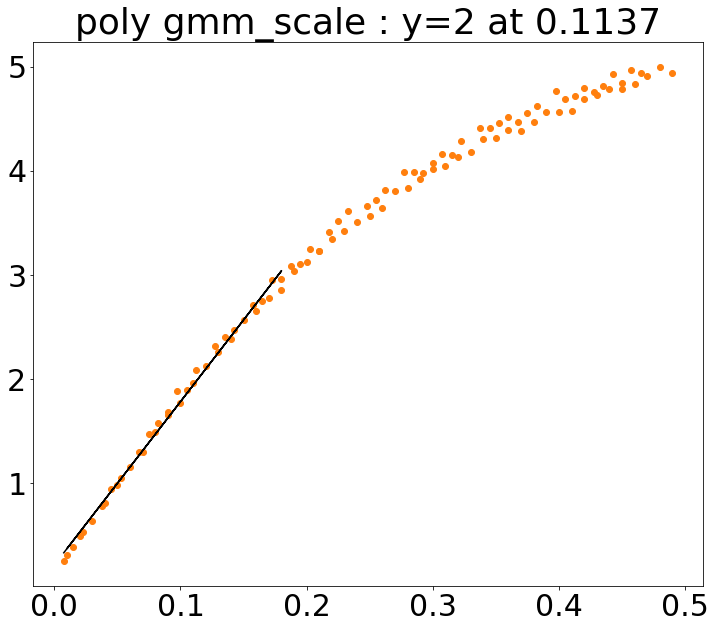

In [6]:
## r0 vs beta
from sklearn.linear_model import LinearRegression
datas = ['comix1', 'comix2', 'comix3', 'poly']
models = ['gmm_none', 'gmm_scale']
colours=['tab:blue','tab:orange']
for data_idx, data in enumerate(datas):
    for model_idx, model in enumerate(models):
        plt.figure(figsize=(12,10))
        overall = {}
        for params in [0,1]:
            for network_idx in range(145):
                # print(data,model,params,network_idx)
                try:
                    with open(f'output_data/gmm/{params}_{network_idx}_{data}_{model}.json','r') as f:
                        res = json.load(f)
                    if model_idx == 0:
                        taus = [np.arange(0.001,0.03,0.001),
                                np.arange(0.001,0.03,0.001),
                                np.arange(0.0005,0.007,0.0005) if network_idx < 85 else np.arange(0.0005,0.005,0.0005),
                                np.arange(0.005,0.11,0.005)]
                    else:
                        if params == 0:
                            taus = [np.arange(0.0005,0.02,0.0005),
                                    np.arange(0.0005,0.15,0.0005),
                                    np.arange(0.01,0.4,0.01) if network_idx < 85 else np.arange(0.01,0.6,0.01),
                                    np.arange(0.0005,0.10,0.0005)]
                            taus = [[15*x for x in a] for a in taus]
                        else:
                            taus = [np.arange(0.0005,0.02,0.0005),
                                    np.arange(0.0005,0.15,0.0005),
                                    np.arange(0.01,0.4,0.01) if network_idx < 85 else np.arange(0.01,0.6,0.01),
                                    np.arange(0.0005,0.10,0.0005)]
                            taus = [[20*x for x in a] for a in taus]
                        taus[2] = np.arange(0.01,0.4,0.01) if network_idx < 85 else np.arange(0.01,0.6,0.01)
                    y = [[a for a in b if a>=0] for b in res['r0_1']]
                    x = [a for i, a in enumerate(taus[data_idx]) if len(y[i])]
                    if len([np.mean(a) for a in y if len(a)>0]) != len(x):
                        continue
                    y = [np.mean(a) for a in y if len(a)>0]
                    # plt.scatter(x,[np.mean(a) for a in y if len(a)>0],color=colours[model_idx])
                    for i, beta in enumerate(x):
                        if beta in overall.keys():
                            overall[beta].append(y[i])
                        else:
                            overall[beta] = [y[i]]
                except:
                    tmp =True
        keys = overall.keys()
        y = [np.mean(overall[key]) for key in keys]
        x = [key for key in keys]
        x, y = [a for i,a in enumerate(x) if y[i] < 5], [a for a in y if a<5]        
        plt.scatter(x,y,color=colours[model_idx])
        ## reduce to body to get line of best fit
        x, y = [a for i,a in enumerate(x) if y[i] < 3], [a for a in y if a<3]
        m = LinearRegression()
        m.fit(np.array(x).reshape(-1,1), y)
        y_pred = m.predict(np.array(x).reshape(-1,1))
        plt.plot(x,y_pred,'k')
        plt.title(f'{data} {model} : y=2 at {np.round((2-m.intercept_)/m.coef_[0],4)}')
        plt.show()
